In [6]:
from scipy.stats import nbinom,poisson,beta,expon,gamma,betaprime,uniform, cauchy, norm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.integrate import quad
from scipy.optimize import fixed_point
from scipy.special import gammaln,logsumexp
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Theoric

In [31]:
def logBF_theo_y(y):
    N = len(y)
    S = np.sum(y)
    return gammaln(N+S+2)-(S+1)*np.log(N+1)-np.sum(gammaln(y+1))-gammaln(N+1)

def logBF_theo_S(S,N):
    return (S-1)*np.log(N)+np.log(N+S)+np.log(N+S+1)-(S+1)*np.log(N+1)

## Bridge

In [53]:

from scipy.optimize import fixed_point
from scipy.special import logsumexp
def func_logBF_logsumexp(logBF,lratio_num,lratio_den):
    num_j = np.array([logsumexp([0,logBF+lratio_num[j]]) for j in range(len(lratio_num))])
    den_i = np.array([logsumexp([lratio_den[i],logBF]) for i in range(len(lratio_den))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den

def logBF_logsumexp_fixedpoint(lratio_num,lratio_den):
    return fixed_point(func_logBF_logsumexp,0,args=(lratio_num,lratio_den))

In [230]:
def func_r_paper(r,l1,l2,lstar):
    return np.sum(np.exp(l2-lstar)/(np.exp(l2-lstar)+r))/np.sum(1/(np.exp(l1-lstar)+r))


def BF_paper(l1,l2,method = "del2"):
    lstar = np.median(l1)
    r = fixed_point(func_r_paper,np.exp(-lstar),args=(l1,l2,lstar),maxiter=100,method=method)
    BF = r*np.exp(lstar)
    return BF

def func_logBF_paper(logBF,l1,l2):
    num_j = np.array([logsumexp([0,logBF-l2[j]]) for j in range(len(l2))])
    den_i = np.array([logsumexp([l1[i],logBF]) for i in range(len(l1))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den

def logBF_paper(l1,l2,method = "del2"):
    logBF = fixed_point(func_logBF_paper,1,args=(l1,l2),maxiter=100,method=method)
    return logBF

def func_BF_dumb(BF,l1,l2):
    num = np.sum(np.exp(l2)/(np.exp(l2)+BF))
    den = np.sum(1/(np.exp(l1)+BF))
    print("Numerator = {} Denominator = {} BF = {}".format(num,den,num/den))
    return num/den

def BF_dumb(l1,l2,method = "del2"):
    BF = fixed_point(func_BF_dumb,4,args=(l1,l2),maxiter=100,method=method)
    print("FIN\nNumerator = {}, Denominator = {} BF = {}".format(np.sum(np.exp(l2)/(np.exp(l2)+BF)),np.sum(1/(np.exp(l1)+BF)),BF))
    return BF

# def fixedpoint(func,x0,maxiter = 100,eps=0,method='iteration',args=()):
#     res = [np.inf,x0]
#     while np.abs(res[-1]-res[-2])>eps and len(res)<maxiter:
#         res.append(func(res[-1],*args)) 
#         print(res[-1])
#     print("CV : {} Maxiter : {}".format(np.abs(res[-1]-res[-2])<eps,len(res)==maxiter))
#     return np.array(res)

# def bisect(f, a=0, b=np.inf, tol=10e-4,args=()):
#     if f(a,*args) * f(b,*args) >= 0:
#         print("You have not assumed right a and b. They should bracket the root.\n")
#         return
#     c = a
#     while (b-a) >= tol:
#         c = (a+b)/2
#         if f(c,*args) == 0.0:
#             break
#         elif f(c,*args)*f(a,*args) < 0:
#             b = c
#         else:
#             a = c
#         print(a,b)
#     return c

# def test_BF(l1,l2):
#     logBF = bisect(func_logBF_paper,-200,200,args=(l1,l2))
#     return logBF

In [55]:
def logratio_pois_nb(mu,y):
    S,N = np.sum(y),len(y)
    return -mu*(N+1)+(N+S+2)*np.log(1+mu)-np.sum(gammaln(y+1))

In [88]:
from scipy.stats import multinomial
def sample_X_poiss_given_S(S,N,T):
    return multinomial.rvs(n=S, p=[1/N]*N,size=T)
    
def sample_nbinom(S,N):
    index = np.random.choice(N+S-1,N-1, replace=False)
    vect = np.append(np.sort(index),N+S-1)
    vect = np.append(-1,vect)
    return vect[1:]-vect[:-1]-1

def sample_X_nbinom_given_S(S,N,T):
    return np.array([sample_nbinom(S,N) for _ in range(T)]) 


In [127]:
N,S=5,5
test = sample_X_nbinom_given_S(S,N,1000000)
value,count=np.unique(test,return_counts=True,axis=0)

In [103]:
from scipy.special import comb

In [126]:
len(value),len(count),comb(N+S-1,N-1)

(126, 126, 126.0)

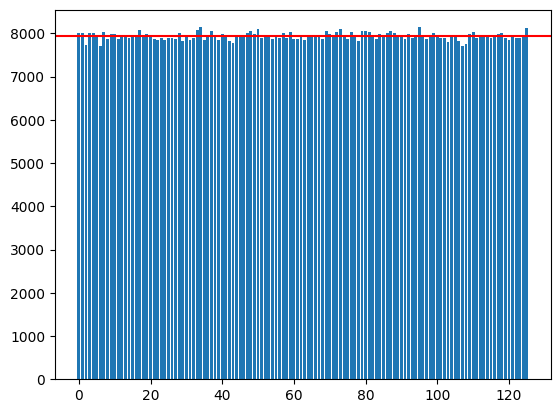

In [129]:
plt.bar(range(len(value)),count)
plt.axhline(len(test)/comb(N+S-1,N-1),color='r')

In [57]:
def post_p_nbinom_unif(S,N,size):
    return beta(1+N,S+1).rvs(size)

def post_nbinom_unif(S,N,size):
    return betaprime(S+1,N+1).rvs(size)

def post_pois_exp(S,N,size):
    return gamma(S+1,scale=1/(N+1)).rvs(size)

In [15]:
def func_BF(args):
    np.random.seed()
    i,S,N,T = args
    X_poiss_S = sample_X_poiss_given_S(S,N,T)
    X_nb_S = sample_X_nbinom_given_S(S,N,T)
    mu_poiss = post_pois_exp(S,N,T)
    mu_nb = post_nbinom_unif(S,N,T)
    l1 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
    l2 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb_S)])

    Bridge = BF_paper(l1,l2)
    logBridge = logBF_paper(l1,l2)
    return Bridge,logBridge

In [16]:
%lprun -f func_BF func_BF((9,1000,10000,1000))

Timer unit: 1e-09 s

Total time: 2.71831 s
File: /var/folders/bk/dp9d4fpn6c9_mvvkgvwr5ry40000gq/T/ipykernel_52179/2730099583.py
Function: func_BF at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def func_BF(args):
     2         1     306000.0 306000.0      0.0      np.random.seed()
     3         1          0.0      0.0      0.0      i,S,N,T = args
     4         1  275100000.0    3e+08     10.1      X_poiss_S = sample_X_poiss_given_S(S,N,T)
     5         1  554332000.0    6e+08     20.4      X_nb_S = sample_X_nbinom_given_S(S,N,T)
     6         1    1368000.0    1e+06      0.1      mu_poiss = post_pois_exp(S,N,T)
     7         1    1061000.0    1e+06      0.0      mu_nb = post_nbinom_unif(S,N,T)
     8         1  819962000.0    8e+08     30.2      l1 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
     9         1  786346000.0    8e+08     28.9      l2 = np.array([logratio_pois_nb(mu

# ABC

In [2]:
def ABC_Model(S,N,T,eps=.001):
    p = np.random.uniform(size=T//2)
    X_nb = nbinom.rvs(1,p, size=(N,T//2))
    #print("X_nb shape: {}".format(X_nb.shape))
    S_nb = np.sum(X_nb, axis=0)
    #print("S_nb shape: {}".format(S_nb.shape))
    d_nb = (S_nb-S)**2
    
    mu = expon(1).rvs(T//2)
    X_pois = poisson.rvs(mu, size=(N,T//2))
    #print("X_pois shape: {}".format(X_pois.shape))
    S_pois = np.sum(X_pois, axis=0)
    d_pois = np.abs(S_pois-S)**2
    
    
    dist = np.concatenate([d_nb,d_pois])
    epsilon = np.quantile(dist,eps)
    pM1 = np.sum(d_pois<epsilon)
    pM2 = np.sum(d_nb<epsilon)
    #print("pM1 = {} pM2 = {}".format(pM1/np.sum(dist<epsilon),pM2/np.sum(dist<epsilon)))
    return pM1/pM2
    

In [3]:
T = 1000000
N = 50
S_list = np.arange(0,4*N+1,(4*N)/(20-1)).astype(int)
ABC = [[ABC_Model(S,N,T) for _ in range(10)] for S in tqdm(S_list)]


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
100%|██████████| 20/20 [13:10<00:00, 39.54s/it]


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa7cb63f890>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa7cb63fed0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa7cb63f4d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fa798a615d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa798a61910>,
 'means': []}

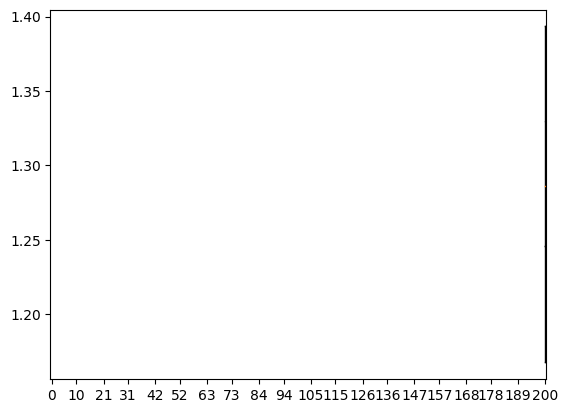

In [4]:
plt.boxplot(ABC,positions=S_list)

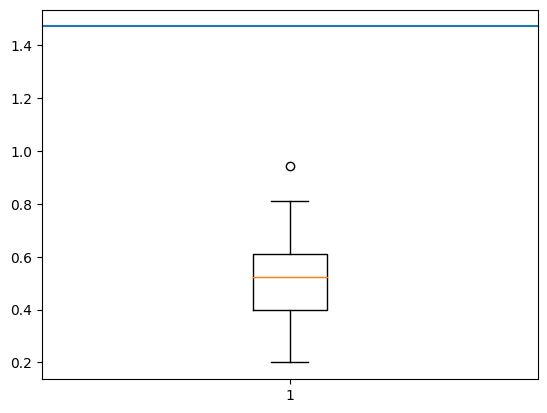

In [750]:
plt.boxplot(ABC)
plt.axhline(np.exp(logBF_S_theo(S,N)))

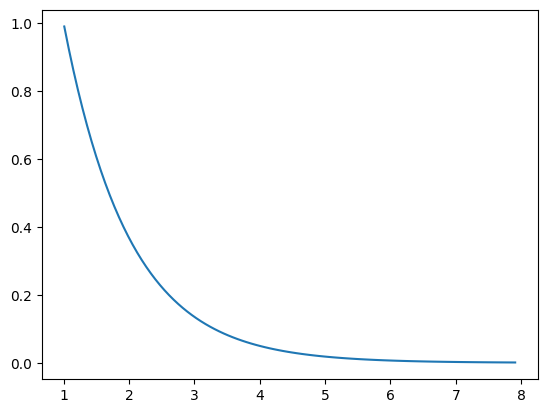

In [700]:
law = expon(1)
x=np.linspace(law.ppf(0.01),law.ppf(0.999), 100)
plt.plot(x,law.pdf(x))


# Paper 

# N = 50

In [1471]:
N = 50 
S_list = np.arange(0,4*N+1,(4*N)/20).astype(int)
T = 1000
n_iter = 1
Theo_list, Bridge_list = [],[]
for S in tqdm(S_list):
    Bridge_S =[]
    lorgBridge_S = []
    Theo = np.exp(logBF_theo_S(S,N))
    for _ in tqdm(range(n_iter)):
        Bridge,logBridge = func_BF((_,S,N,T))
        Bridge_S.append(Bridge)
        lorgBridge_S.append(logBridge)
    Theo_list.append(Theo)
    Bridge_list.append(Bridge_S)
    print("S = {} Theo = {} Bridge = {} logBridge = {}".format(S,Theo,np.mean(Bridge_S),np.mean(lorgBridge_S)))


  5%|▍         | 1/21 [00:01<00:29,  1.47s/it]

S = 0 Theoretical logBF = 1.0 Bridge logBF = 1.0002302824982587


 10%|▉         | 2/21 [00:02<00:27,  1.45s/it]

S = 10 Theoretical logBF = 1.1774410892325742 Bridge logBF = 1.1954474995111493


 14%|█▍        | 3/21 [00:04<00:26,  1.45s/it]

S = 20 Theoretical logBF = 1.3116343237439545 Bridge logBF = 1.281680093268881


 19%|█▉        | 4/21 [00:05<00:24,  1.44s/it]

S = 30 Theoretical logBF = 1.40290955317249 Bridge logBF = 1.4037731871122339


 24%|██▍       | 5/21 [00:07<00:23,  1.44s/it]

S = 40 Theoretical logBF = 1.454577451124397 Bridge logBF = 1.3954777962015115


 29%|██▊       | 6/21 [00:08<00:21,  1.44s/it]

S = 50 Theoretical logBF = 1.4715418076401625 Bridge logBF = 1.5666574013243093


 33%|███▎      | 7/21 [00:10<00:20,  1.45s/it]

S = 60 Theoretical logBF = 1.4593692052804916 Bridge logBF = 1.6854708026862197


 38%|███▊      | 8/21 [00:11<00:18,  1.45s/it]

S = 70 Theoretical logBF = 1.4236866498229033 Bridge logBF = 1.2321020279068546


 38%|███▊      | 8/21 [00:12<00:21,  1.62s/it]


KeyboardInterrupt: 

In [1503]:
import os
os.getcwd()

'/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures'

In [17]:
import csv

filepath = './data/Poiss_Geo_50.csv'
test_sim = []

with open(filepath, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        test_sim.append(row)
test_sim = np.array(test_sim).astype(float)[1:].T
test_sim.shape

(11, 100)

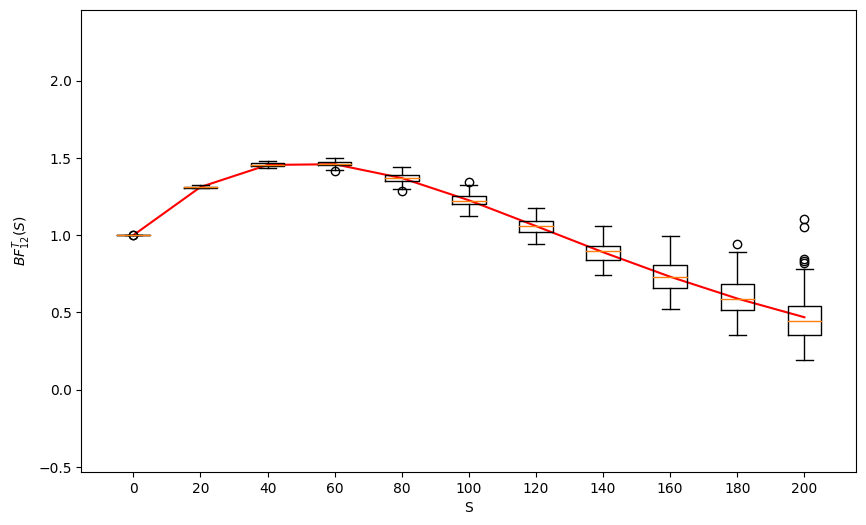

In [19]:
import matplotlib.pyplot as plt
N = 50
S_list = np.arange(0,4*N+1,(4*N)/10).astype(int)
Theo_list = [np.exp(logBF_theo_S(S,N)) for S in S_list]

plt.figure(figsize=(10, 6))  # Adjust the figure size as desired
plt.plot(S_list, Theo_list, color="red")
plt.boxplot(list(test_sim), positions=S_list,widths=10)

plt.xlabel('S')
plt.ylabel('$BF_{12}^{T}(S)$')
plt.ylim(np.min(Theo_list)-1,np.max(Theo_list)+1)
plt.show()


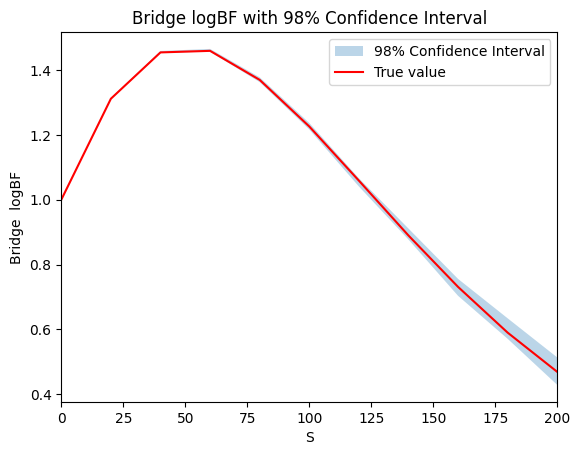

In [20]:
# Calculate the mean and standard deviation of Bridge_list
N = 50
S_list = np.arange(0,4*N+1,(4*N)/10).astype(int)
mean_bridge = np.mean(test_sim, axis=1)
std_bridge = np.std(test_sim, axis=1)
alpha = 0.01
n_iter = len(test_sim[0])

confidence_interval = norm.ppf(1-alpha/2) * std_bridge / np.sqrt(n_iter)

#plt.plot(S_list, mean_bridge, label='Bridge mean logBF')
plt.fill_between(S_list, mean_bridge - confidence_interval, mean_bridge + confidence_interval, alpha=0.3, label='{}% Confidence Interval'.format(int(100-100*2*alpha)))
plt.plot(S_list, Theo_list, color='red', label='True value')
plt.xlabel('S')
plt.ylabel('Bridge  logBF')
plt.title('Bridge logBF with {}% Confidence Interval'.format(int(100-100*2*alpha)))

plt.legend()
plt.xlim(0,200)
plt.show()


# N = 100

In [1371]:
N = 100
S_list = np.arange(0,4*N+1,(4*N)/20).astype(int)
T = 10000
n_iter = 100
Theo_list2, Bridge_list2 = [],[]
logBridge2 = []
for S in tqdm(S_list):
    Bridge_S =[]
    logBridge_S = []
    Theo = np.exp(logBF_theo_S(S,N))
    for _ in tqdm(range(n_iter)):
        X_poiss_S = sample_X_poiss_given_S(S,N,T)
        X_nb_S = sample_X_nbinom_given_S(S,N,T)
        mu_poiss = post_pois_exp(S,N,T)
        mu_nb = post_nbinom_unif(S,N,T)
        l1 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb_S)])
        l2 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
        Bridge = BF_paper(l1,l2)
        Bridge_S.append(Bridge)
        logBridge_S.append(logBF_logsumexp_fixedpoint(l1,l2))
    print("S = {} Theoretical logBF = {} Bridge logBF = {}".format(S,Theo,np.mean(Bridge_S)))
    Theo_list2.append(Theo)
    Bridge_list2.append(Bridge_S)
    logBridge2.append(logBridge_S)
    

  5%|▍         | 1/21 [06:23<2:07:54, 383.72s/it]

S = 0 Theoretical logBF = 1.0 Bridge logBF = 0.9999963276956252


 10%|▉         | 2/21 [14:14<2:17:43, 434.94s/it]

S = 20 Theoretical logBF = 1.1781966048809625 Bridge logBF = 1.177184888853847


 14%|█▍        | 3/21 [22:49<2:21:25, 471.43s/it]

S = 40 Theoretical logBF = 1.3127161347628895 Bridge logBF = 1.3142729077152515


 19%|█▉        | 4/21 [32:38<2:26:42, 517.79s/it]

S = 60 Theoretical logBF = 1.4039190204511083 Bridge logBF = 1.4069068908852205


 24%|██▍       | 5/21 [42:39<2:26:06, 547.88s/it]

S = 80 Theoretical logBF = 1.4551903416535221 Bridge logBF = 1.4562201339285459


 29%|██▊       | 6/21 [52:37<2:21:16, 565.09s/it]

S = 100 Theoretical logBF = 1.4715238352109996 Bridge logBF = 1.4950521001150068


 33%|███▎      | 7/21 [1:03:43<2:19:31, 597.97s/it]

S = 120 Theoretical logBF = 1.4585748701322143 Bridge logBF = 1.4584065557315353


 38%|███▊      | 8/21 [1:14:52<2:14:27, 620.57s/it]

S = 140 Theoretical logBF = 1.422049064366613 Bridge logBF = 1.447883406689913


 43%|████▎     | 9/21 [1:26:03<2:07:15, 636.28s/it]

S = 160 Theoretical logBF = 1.3673279023232554 Bridge logBF = 1.3858197472751141


 48%|████▊     | 10/21 [1:37:22<1:59:04, 649.53s/it]

S = 180 Theoretical logBF = 1.2992588884555987 Bridge logBF = 0.8181874393827474


 52%|█████▏    | 11/21 [1:49:45<1:53:01, 678.13s/it]

S = 200 Theoretical logBF = 1.222057441695529 Bridge logBF = -3.157942663781077


 57%|█████▋    | 12/21 [2:02:16<1:45:01, 700.21s/it]

S = 220 Theoretical logBF = 1.1392824431526853 Bridge logBF = -0.5931097834661068


 62%|██████▏   | 13/21 [2:14:49<1:35:30, 716.37s/it]

S = 240 Theoretical logBF = 1.0538582857209389 Bridge logBF = -0.16890985863813426


 67%|██████▋   | 14/21 [2:27:53<1:25:56, 736.68s/it]

S = 260 Theoretical logBF = 0.9681243542037562 Bridge logBF = 0.6615808443483132


 71%|███████▏  | 15/21 [2:41:33<1:16:10, 761.68s/it]

S = 280 Theoretical logBF = 0.88389878998228 Bridge logBF = -12.886854858733294


 76%|███████▌  | 16/21 [2:55:22<1:05:10, 782.14s/it]

S = 300 Theoretical logBF = 0.802547701707081 Bridge logBF = 0.030050953830416748


 81%|████████  | 17/21 [3:25:14<1:12:22, 1085.74s/it]

S = 320 Theoretical logBF = 0.7250540821190277 Bridge logBF = 0.18916476599727455


 86%|████████▌ | 18/21 [5:46:42<2:45:30, 3310.03s/it]

S = 340 Theoretical logBF = 0.6520828917522234 Bridge logBF = 0.7878212174300627


 90%|█████████ | 19/21 [6:02:46<1:26:51, 2605.51s/it]

S = 360 Theoretical logBF = 0.5840403082908512 Bridge logBF = 0.527327016662651


 95%|█████████▌| 20/21 [6:19:31<35:25, 2125.03s/it]  

S = 380 Theoretical logBF = 0.5211261932503274 Bridge logBF = 0.8755091063323581


100%|██████████| 21/21 [6:37:02<00:00, 1134.41s/it]

S = 400 Theoretical logBF = 0.46337952854965475 Bridge logBF = 0.895649135778352


In [22]:
import csv

filepath = './data/Poiss_Geo_100.csv'
test_sim2 = []

with open(filepath, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        test_sim2.append(row)
test_sim2 = np.array(test_sim2).astype(float)[1:].T
test_sim2.shape

(11, 100)

11 11 11


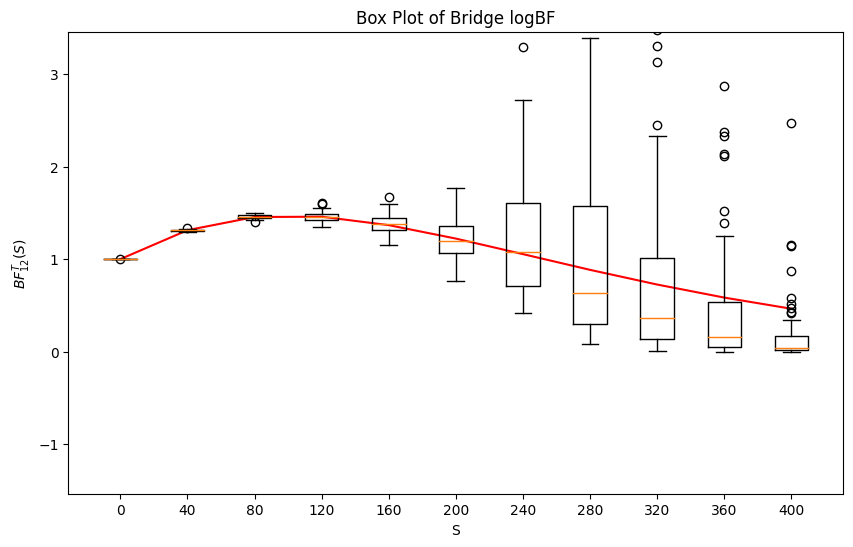

In [23]:
import matplotlib.pyplot as plt
N = 100
S_list = list(np.arange(0,4*N+1,(4*N)/10).astype(int))
Theo_list2 = list([np.exp(logBF_theo_S(S,N)) for S in S_list])
test_sim2 = list(test_sim2)
print(len(S_list), len(Theo_list2), len(test_sim2))
plt.figure(figsize=(10, 6))  # Adjust the figure size as desired
plt.plot(S_list, Theo_list2, color="red")
plt.boxplot(test_sim2, positions=S_list,widths=20)

plt.xlabel('S')
plt.ylabel('$BF_{12}^{T}(S)$')
plt.title('Box Plot of Bridge logBF')
plt.ylim(np.min(Theo_list2)-2,np.max(Theo_list2)+2)

plt.show()


In [1395]:
np.array(logBridge2).shape

(21, 100)

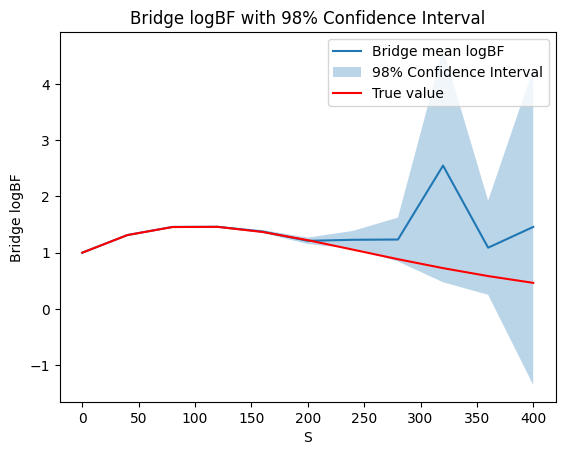

In [25]:
# Calculate the mean and standard deviation of Bridge_list
N = 100
S_list = np.arange(0,4*N+1,(4*N)/10).astype(int)
mean_bridge = np.mean(test_sim2, axis=1)
std_bridge = np.std(test_sim2, axis=1)
alpha = 0.01
n_iter = len(test_sim2[0])
confidence_interval = norm.ppf(1-alpha/2) * std_bridge / np.sqrt(n_iter)

plt.plot(S_list, mean_bridge, label='Bridge mean logBF')
plt.fill_between(S_list, mean_bridge - confidence_interval, mean_bridge + confidence_interval, alpha=0.3, label='{}% Confidence Interval'.format(int(100-100*2*alpha)))
plt.plot(S_list, Theo_list2, color='red', label='True value')
plt.xlabel('S')
plt.ylabel('Bridge logBF')
plt.title('Bridge logBF with {}% Confidence Interval'.format(int(100-100*2*alpha)))

plt.legend()
plt.show()


# N = 200

In [54]:
def func_dumb(BF,l1,l2):
    return np.sum(l2/(l2+BF))/np.sum(1/(l1+BF))

def BF_dumb(l1,l2):
    return fixed_point(func_dumb,1,args=(l1,l2),maxiter=10000)

In [63]:
from tqdm.contrib import tzip
from time import sleep

In [64]:
N=200
S = 800
T=1000000
X_poiss_S = sample_X_poiss_given_S(S,N,T)
X_nb_S = sample_X_nbinom_given_S(S,N,T)
mu_poiss = post_pois_exp(S,N,T)
mu_nb = post_nbinom_unif(S,N,T)

l1 = np.array([logratio_pois_nb(mu,X) for mu,X in (tzip(mu_poiss,X_poiss_S))])
l2 = np.array([logratio_pois_nb(mu,X) for mu,X in (tzip(mu_nb,X_nb_S))])

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [81]:
np.std(l1),np.std(l2)

(8.819011982307371, 32.7309662752395)

In [65]:
logBF_logsumexp_fixedpoint(lratio_den=l1,lratio_num=-l2),logBF_paper(l1,l2)

(array(-15.4713076), array(-15.4713076))

In [73]:
logBF_paper(-l2,-l1)

array(15.4713076)

In [69]:
np.log(BF_paper(l1,l2))

-15.47130760040376

In [68]:
logBF_theo_S(S,N)

-0.7751454251410905

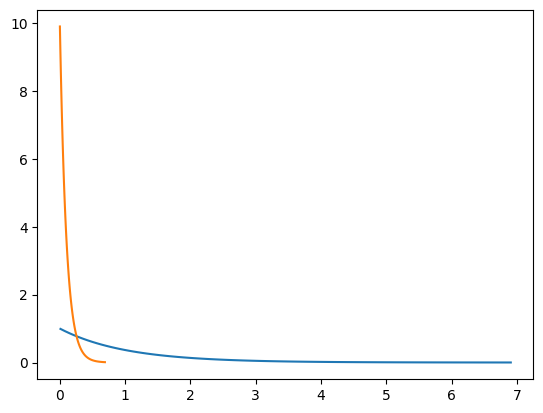

In [72]:
law1=expon(scale=1)
x = np.linspace(law1.ppf(0.01),law1.ppf(0.999), 100)
plt.plot(x,law1.pdf(x))
law10=expon(scale=1/10)
x = np.linspace(law10.ppf(0.01),law10.ppf(0.999), 100)
plt.plot(x,law10.pdf(x))

In [56]:
BF_dumb(l1,l2)

RuntimeError: Failed to converge after 10000 iterations, value is -1558.2559061804889

In [84]:
160*5/4


200.0

# Convergence test

[160 320 480 640 800]


  0%|          | 0/5 [00:00<?, ?it/s]

Theoretical BF: 1.4555052240987099 logBF: 0.375353073409542


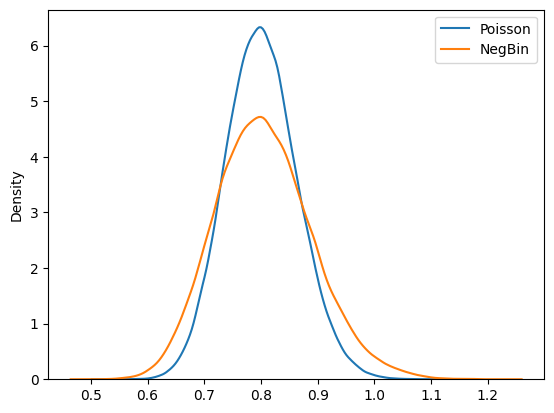

Bridge...
l1: min = -7.509259248418772 max = 27.93242878595351 mean = 12.010326665341468
l2: min = -54.725467476339034 max = 9.171948622231852 mean = -16.34299937788928

BF = 1.4536183108437328 with log BF = 0.37405583491353145
Bridge...
l1: min = -8.013665664309372 max = 28.293835934148262 mean = 12.006140748973815
l2: min = -51.90742066643409 max = 10.931239458793094 mean = -16.308732624633507

BF = 1.4017517130147101 with log BF = 0.33772267807526557
Bridge...
l1: min = -9.675316718643465 max = 29.02876232144468 mean = 11.99637088088931
l2: min = -56.3433612932798 max = 11.016091031592964 mean = -16.315437680322994

BF = 1.4475260008302924 with log BF = 0.3698558928807465
Bridge...
l1: min = -6.890827386879536 max = 27.888436889009277 mean = 11.974401077195981
l2: min = -56.4263553182155 max = 10.927326032610843 mean = -16.259028847272674

BF = 1.497648096255038 with log BF = 0.4038959417804105
Bridge...
l1: min = -8.160197308445078 max = 28.825400278316252 mean = 11.985772080840789
l2: min = -54.29898054017539 max = 12.956390829010104 mean = -16.314411867652364

 20%|██        | 1/5 [04:02<16:10, 242.54s/it]

BF = 1.4674328304386353 with log BF = 0.38351450025085665
S = 160 Theoretical logBF = 1.4555052240987099 Bridge logBF = 1.4535953902764818
Theoretical BF: 1.3660772276820818 logBF: 0.31194329518893943


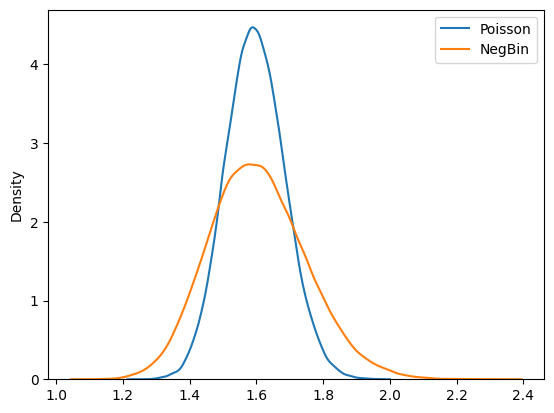

Bridge...
l1: min = 2.022130812693547 max = 55.007919851131675 mean = 31.4410871036414
l2: min = -125.08282371175153 max = 2.442060431724798 mean = -51.010707643937025

BF = 5.249675297952959 with log BF = 1.6581662266819053
Bridge...
l1: min = 0.6373336237519425 max = 56.80396853160596 mean = 31.45964943595075
l2: min = -126.65924676255628 max = -0.5591573995730812 mean = -51.01128519192444

BF = 0.5136043907276449 with log BF = -0.6663019777183852
Bridge...
l1: min = 1.787179921799634 max = 54.43757642707507 mean = 31.453227050548126
l2: min = -124.88261767532236 max = -0.6862720259354944 mean = -51.02868266149381

BF = 1.2971686898154322 with log BF = 0.26018395841553643
Bridge...
l1: min = -10.73922010079167 max = 56.52333585265691 mean = 31.41986816865139
l2: min = -120.47296434511071 max = 2.067399696904573 mean = -51.04985115913052

BF = 1.7221473142050507 with log BF = 0.5435719506653357
Bridge...
l1: min = 2.3007177769085843 max = 57.316985079320105 mean = 31.448710496697522
l2: min = -125.54034773109822 max = -1.6327604664402884 mean = -50.992639196207904

 40%|████      | 2/5 [09:28<14:34, 291.49s/it]

BF = 1.3822007068089237 with log BF = 0.32367694404018593
S = 320 Theoretical logBF = 1.3660772276820818 Bridge logBF = 2.032959279902002
Theoretical BF: 1.0512846625004904 logBF: 0.0500129044135065


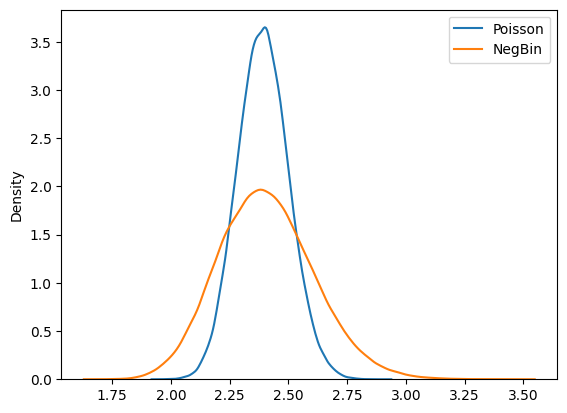

Bridge...
l1: min = 13.179240898322462 max = 78.97232775305088 mean = 50.448636080053014
l2: min = -196.97823258381015 max = -6.664145871236599 mean = -94.44233078539308

BF = 25.73904782713044 with log BF = 3.2480092095307875
Bridge...
l1: min = 14.97022461298468 max = 80.57457784865875 mean = 50.47240389737525
l2: min = -203.8987971012658 max = -9.749146356672611 mean = -94.49918051035432

BF = 8.444623259400148 with log BF = 2.1335299381811965
Bridge...
l1: min = 14.48381731913912 max = 82.6172122119803 mean = 50.43288199740079
l2: min = -220.7957412013668 max = -25.602934384102923 mean = -94.322191338944

BF = 0.006484943175617586 with log BF = -5.0382722236858
Bridge...
l1: min = 17.302819579186178 max = 80.01254915509793 mean = 50.42473940702878
l2: min = -198.19876662754962 max = -23.506313237744905 mean = -94.63557192789324

BF = 0.03207950202140544 with log BF = -3.439538019127827
Bridge...
l1: min = 11.557710785367192 max = 79.98956285268537 mean = 50.44150882622566
l2: min = -209.71441255288119 max = -21.586332813416618 mean = -94.44982481605807

 60%|██████    | 3/5 [14:04<09:29, 284.55s/it]

BF = 0.0075620068984312136 with log BF = -4.884618661264247
S = 480 Theoretical logBF = 1.0512846625004904 Bridge logBF = 6.845959507725207
Theoretical BF: 0.7220540438867132 logBF: -0.3256552898619703


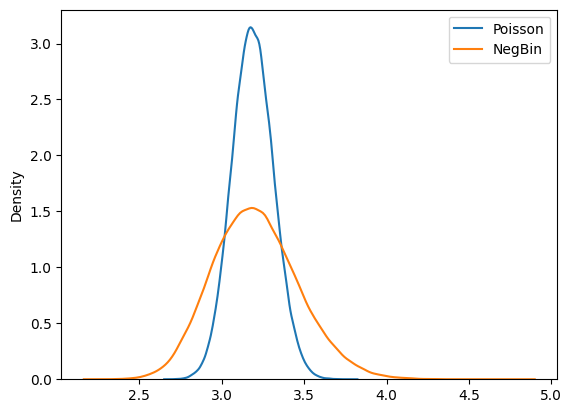

Bridge...
l1: min = 25.881962106692527 max = 99.87545145390584 mean = 67.42473431150026
l2: min = -265.2621490718859 max = -43.69118224898045 mean = -142.8665028370786

BF = 0.00014586071755341135 with log BF = -8.832858380953601
Bridge...
l1: min = 19.69841118911438 max = 99.4528017171312 mean = 67.4075892513265
l2: min = -300.08697185213146 max = -42.74968475066214 mean = -143.09719524370908

BF = 9.87078603887556e-06 with log BF = -11.525931068492799
Bridge...
l1: min = 24.189788509496793 max = 101.41620366176562 mean = 67.42856814559131
l2: min = -272.1634300352115 max = -37.30109481212139 mean = -142.83596003810095

BF = 0.001416746408063257 with log BF = -6.559392298253383
Bridge...
l1: min = 26.034886637614704 max = 97.78267703585618 mean = 67.43760329110944
l2: min = -282.798273862447 max = -45.32818483638823 mean = -143.0642816098797

BF = 5.079995513262547e-05 with log BF = -9.887615086596261
Bridge...
l1: min = 14.407734187552933 max = 99.38722675506637 mean = 67.40790369140932
l2: min = -269.55355069347263 max = -43.53676326463358 mean = -142.90036845260323

 80%|████████  | 4/5 [17:12<04:06, 246.38s/it]

BF = 4.7334171721501535e-07 with log BF = -14.56344826274999
S = 640 Theoretical logBF = 0.7220540438867132 Bridge logBF = 0.00032475024170107686
Theoretical BF: 0.46063678795796736 logBF: -0.7751454251410906


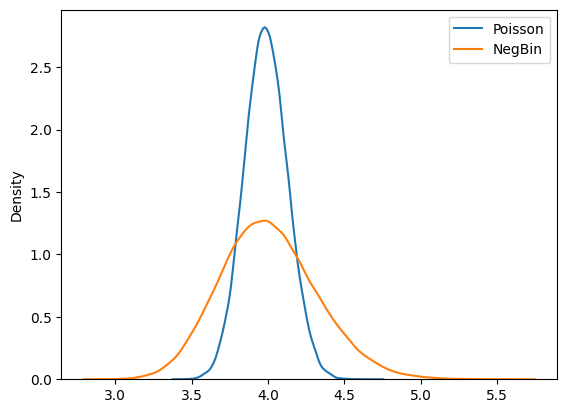

Bridge...
l1: min = 39.11551955113748 max = 114.44740332288336 mean = 82.30149328726746
l2: min = -371.14035463063703 max = -71.95605417165052 mean = -194.79356495166806

BF = 6.272336932113988e-08 with log BF = -16.584531742303444
Bridge...
l1: min = 43.73977101263813 max = 116.2205864442393 mean = 82.34665372789372
l2: min = -373.2065427440991 max = -75.3966612463106 mean = -194.7980720597706

BF = 8.753297816452886e-08 with log BF = -16.251250221280383
Bridge...
l1: min = 30.843265800754466 max = 115.0947529478907 mean = 82.33004131257235
l2: min = -354.0946218123381 max = -67.9344395462158 mean = -194.7612418501905

BF = 8.872754767281563e-09 with log BF = -18.540280517559047
Bridge...
l1: min = 42.05877607085563 max = 117.77049569205133 mean = 82.34691116562114
l2: min = -367.0960326693987 max = -75.59074246742671 mean = -194.92933550835826

BF = 4.3870834810906836e-08 with log BF = -16.942016092751555
Bridge...
l1: min = 41.47561038578783 max = 116.82731241109673 mean = 82.33989654904961
l2: min = -354.9442246998615 max = -73.27977330009264 mean = -194.61944373627267

100%|██████████| 5/5 [20:31<00:00, 246.33s/it]

BF = 1.162433053686103e-07 with log BF = -15.967580382364218
S = 800 Theoretical logBF = 0.46063678795796736 Bridge logBF = 6.384864848649348e-08


In [42]:
N = 200
S_list = np.arange((4*N)/5,4*N+1,(4*N)/5).astype(int)
S_list= 800
print(S_list)
T = 100000
n_iter = 5
Theo_list3, Bridge_list3 = [],[]
logBridge3 = []
L1, L2 = [],[]
Mu_poiss, Mu_nb = [],[]
for S in tqdm(S_list):
    Bridge_S =[]
    logBridge_S = []
    Mu_poiss_S = []
    Mu_nb_S = []
    
    L1_S, L2_S = [],[]
    Theo = np.exp(logBF_theo_S(S,N))
    print('Theoretical BF: {} logBF: {}'.format(Theo,np.log(Theo)))
    for k in tqdm(range(n_iter)):
        X_poiss_S = sample_X_poiss_given_S(S,N,T)
        X_nb_S = sample_X_nbinom_given_S(S,N,T)
        mu_poiss = post_pois_exp(S,N,T)
        mu_nb = post_nbinom_unif(S,N,T)
        Mu_poiss_S.append(mu_poiss)
        Mu_nb_S.append(mu_nb)
        if k==0:
            sns.kdeplot(mu_poiss,label='Poisson')
            sns.kdeplot(mu_nb,label='NegBin')
            plt.legend()
            plt.show()
       
        l1 = np.array([logratio_pois_nb(mu,X) for mu,X in (zip(mu_poiss,X_poiss_S))])
        l2 = np.array([logratio_pois_nb(mu,X) for mu,X in (zip(mu_nb,X_nb_S))])
        L1_S.append(l1)
        L2_S.append(l2)
        print('Bridge...\nl1: min = {} max = {} mean = {}\nl2: min = {} max = {} mean = {}'.format(np.min(l1),np.max(l1),np.mean(l1),np.min(l2),np.max(l2),np.mean(l2)),end="")
        Bridge = BF_paper(l1,l2)
        Bridge_S.append(Bridge)
        logBridge_S.append(logBF_paper(l1,l2))
        print("BF = {} with log BF = {}".format(Bridge,logBF_paper(l1,l2)))
    print("S = {} Theoretical logBF = {} Bridge logBF = {}".format(S,Theo,np.mean(Bridge_S)))
    Theo_list3.append(Theo)
    Bridge_list3.append(Bridge_S)
    logBridge3.append(logBridge_S)
    L1.append(L1_S)
    L2.append(L2_S)
    Mu_poiss.append(Mu_poiss_S)
    Mu_nb.append(Mu_nb_S)
    

In [86]:
L1 = np.array(L1)
L2 = np.array(L2)
L1.shape, L2.shape

((5, 5, 100000), (5, 5, 100000))

In [89]:
std_l1,std_l2=np.std(L1.reshape(5,-1),axis=1),np.std(L2.reshape(5,-1),axis=1)

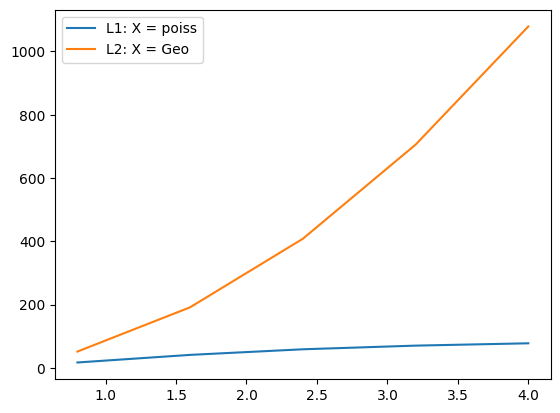

In [98]:
N = 200
S_list = np.arange((4*N)/5,4*N+1,(4*N)/5).astype(int)/N
plt.plot(S_list,std_l1**2,label="L1: X = poiss")
plt.plot(S_list,std_l2**2, label = "L2: X = Geo")

plt.legend()

In [288]:
l1,l2 = L1[1][0],L2[1][0]

In [289]:
np.std(l1),np.std(l2)

(6.437571256539315, 13.828370016635049)

In [191]:
N = 200
S_list = np.arange((4*N)/5,4*N+1,(4*N)/5).astype(int)
N,S_list[2],logBF_S_theo_pois_nb(S_list[2],N)

(200, 480, 0.05001290441475703)

# here

In [210]:
index = np.random.choice(len(l1),10000,replace=False)
l1bis,l2bis = l1[index],l2[index]

In [216]:
N = 200
S = 300
T = 10000
L1, L2 = [],[]
LBF = []
for S in [100,200,300,400,500]:
    LBF_S, L1_S, L2_S = [],[],[]
    for i in tqdm(range(50)):
        X_poiss_S = sample_X_poiss_given_S(S,N,T)
        X_nb_S = sample_X_nbinom_given_S(S,N,T)
        mu_poiss = post_pois_exp(S,N,T)
        mu_nb = post_nbinom_unif(S,N,T)
        l1 = np.array([logratio_pois_nb(mu,X) for mu,X in (zip(mu_poiss,X_poiss_S))])
        l2 = np.array([logratio_pois_nb(mu,X) for mu,X in (zip(mu_nb,X_nb_S))])
        Bridge = BF_paper(l1,l2)
        logBridge = logBF_paper(l1,l2)
        print("N = {} S = {} Theo = {} Bridge = {}".format(N,S,logBF_theo_S(S,N),logBridge))
        L1_S.append(l1)
        L2_S.append(l2)
        LBF_S.append(Bridge)
    L1.append(L1_S)
    L2.append(L2_S)
    LBF.append(LBF_S)
    

X_poiss_S = sample_X_poiss_given_S(S,N,T)
X_nb_S = sample_X_nbinom_given_S(S,N,T)
mu_poiss = post_pois_exp(S,N,T)
mu_nb = post_nbinom_unif(S,N,T)


l1 = np.array([logratio_pois_nb(mu,X) for mu,X in (zip(mu_poiss,X_poiss_S))])
l2 = np.array([logratio_pois_nb(mu,X) for mu,X in (zip(mu_nb,X_nb_S))])
print("Theorical BF: {} logBF: {}".format(np.exp(logBF_theo_S(S,N)),logBF_theo_S(S,N)))
bridge = BF_paper(l1,l2)
logbridge = logBF_paper(l1,l2)
print("BF: {} logBF: {}".format(bridge,logbridge))

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:02<02:02,  2.50s/it]

N = 200 S = 100 Theo = 0.31051631369405186 Bridge = 0.3719433982622615


  4%|▍         | 2/50 [00:04<01:59,  2.48s/it]

N = 200 S = 100 Theo = 0.31051631369405186 Bridge = 0.2868255597253313


  6%|▌         | 3/50 [00:07<01:58,  2.52s/it]

N = 200 S = 100 Theo = 0.31051631369405186 Bridge = 0.27040995490929465


  6%|▌         | 3/50 [00:09<02:34,  3.29s/it]


KeyboardInterrupt: 

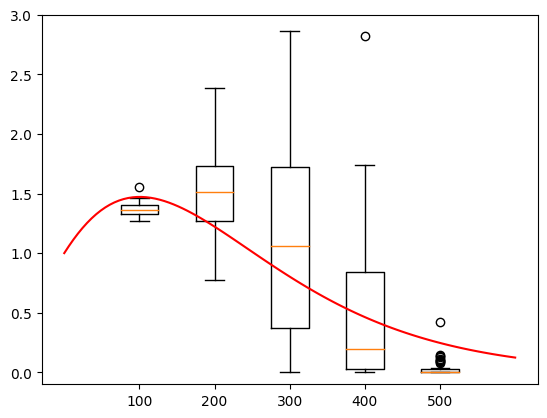

In [156]:
plt.boxplot(list((LBF)), positions=[100,200,300,400,500],widths=50)
x = np.linspace(0,600,100)
y = np.exp(logBF_theo_S(x,N))
plt.ylim(-0.1,3)
plt.plot(x,y,color='red')


# test

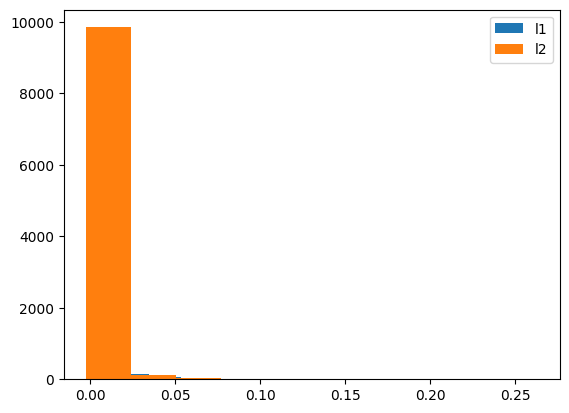

Theorical BF: 1.0 logBF: 0.0
Numerator = 2000.088981406322 Denominator = 2000.0011111897365 BF = 1.0000439350838826
Numerator = 4999.984566194272 Denominator = 4999.931731127857 BF = 1.0000105671575645
Numerator = 5000.067983459045 Denominator = 5000.015151930508 BF = 1.0000105662736873
Numerator = 5000.067984740834 Denominator = 5000.015153212351 BF = 1.000010566273674
FIN
Numerator = 5000.067984740866, Denominator = 5000.015153212384 BF = 1.000010566273674
Numerator = 9999.99990000101 Denominator = 10000.386314543584 BF = 0.9999613600384605
Numerator = 9801.981241781363 Denominator = 9802.342190049458 BF = 0.9999631773446492
Numerator = 9611.652963457753 Denominator = 9611.990022534375 BF = 0.9999649334762278
Numerator = 9428.575576779447 Denominator = 9428.890204819294 BF = 0.9999666314875864
Numerator = 9252.342456499498 Denominator = 9252.636003482135 BF = 0.9999682742320646
Numerator = 9082.576824947902 Denominator = 9082.850542295699 BF = 0.9999698643783115
Numerator = 8918.9290

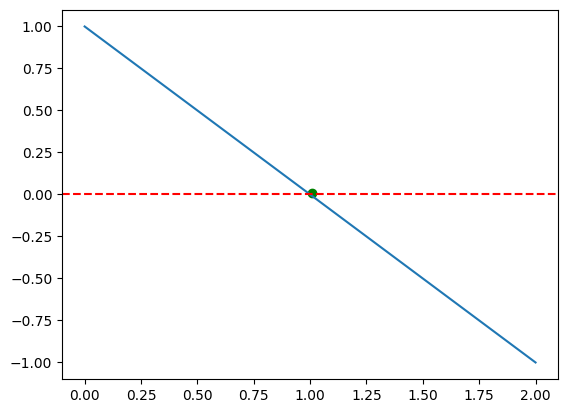

BF: 1.000010566273674 logBF: 1.0566217852669979e-05
Dumb BF : 1.000010566273674


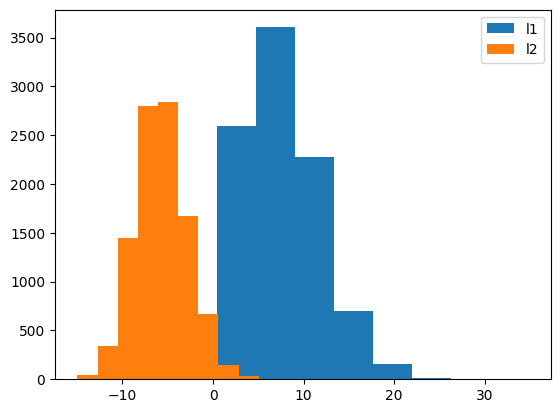

Theorical BF: 1.3641292509515173 logBF: 0.31051631369405186
Numerator = 220.48168046858808 Denominator = 299.33248587230474 BF = 0.7365778553105178
Numerator = 595.6652883270414 Denominator = 795.0542196556801 BF = 0.7492134166459873
Numerator = 590.1718827163041 Denominator = 787.8655052495831 BF = 0.7490769411580562
Numerator = 590.2097127598403 Denominator = 787.9150113472379 BF = 0.7490778881730584
Numerator = 590.209308774265 Denominator = 787.9144826736385 BF = 0.7490778780604482
Numerator = 590.2093087744041 Denominator = 787.9144826738204 BF = 0.7490778780604519
FIN
Numerator = 590.2093087744026, Denominator = 787.9144826738184 BF = 0.7490778780604519
Numerator = 9999.124067805258 Denominator = 13245.760794557464 BF = 0.7548923933394439
Numerator = 3054.391943968797 Denominator = 4158.8590961360815 BF = 0.7344302543951479
Numerator = 2395.794762216863 Denominator = 3235.196821416407 BF = 0.7405406516095537
Numerator = 2052.9267658998197 Denominator = 2756.350759439168 BF = 0.74

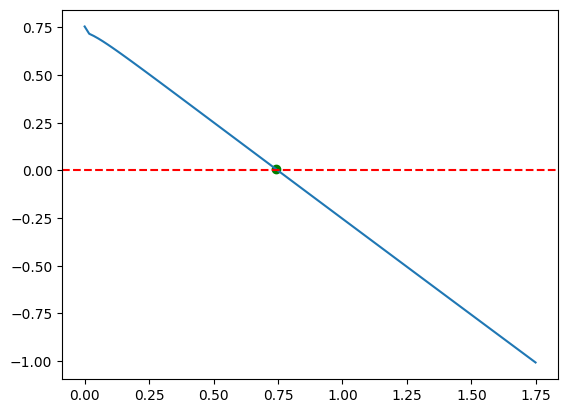

BF: 0.7490778780604518 logBF: -0.28891232482139806
Dumb BF : 0.7490778780604519


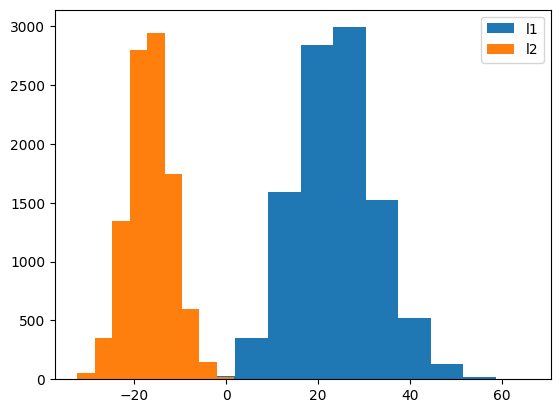

Theorical BF: 1.4715192898853824 logBF: 0.3862953975999517
Numerator = 4.355430594334768 Denominator = 6.019902530540303 BF = 0.7235051684373128
Numerator = 13.037637280120094 Denominator = 15.260973101944426 BF = 0.8543123163266009
Numerator = 11.7847487203347 Denominator = 14.021174770047656 BF = 0.8404965285440662
Numerator = 11.862635024911 Denominator = 14.098694087726843 BF = 0.8413995616258977
Numerator = 11.855327639564688 Denominator = 14.091423886562838 BF = 0.8413150959761827
Numerator = 11.855330952704271 Denominator = 14.091427182971731 BF = 0.841315134284653
Numerator = 11.855330643062869 Denominator = 14.091426874893958 BF = 0.8413151307043975
Numerator = 11.855330643062873 Denominator = 14.091426874893962 BF = 0.8413151307043975
FIN
Numerator = 11.855330643062873, Denominator = 14.091426874893962 BF = 0.8413151307043975
Numerator = 6364.117075928107 Denominator = 261.6289614305882 BF = 24.324971674118526
Numerator = 96.06245303461179 Denominator = 102.15396577755473 BF 

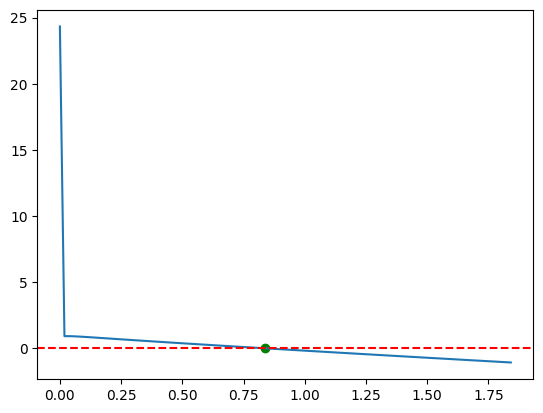

BF: 0.8413151307043975 logBF: -0.17278897967755397
Dumb BF : 0.8413151307043975


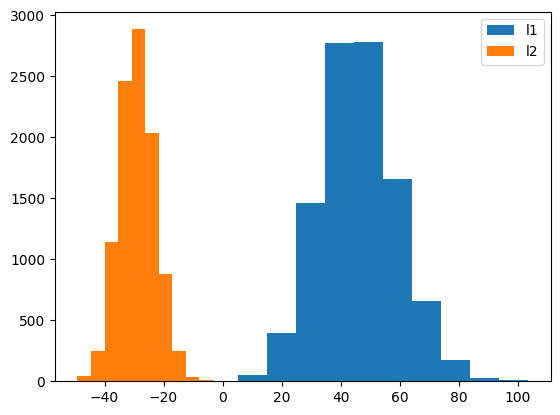

Theorical BF: 1.3956070355968078 logBF: 0.33332947158805837
Numerator = 0.012461471634732213 Denominator = 0.01237044962546459 BF = 1.0073580194757232
Numerator = 0.048440157106297954 Denominator = 0.012485041119897483 BF = 3.879855632121114
Numerator = 0.02006572405699622 Denominator = 0.012428562610639782 BF = 1.6144846902745178
Numerator = 0.030546530097577802 Denominator = 0.012461561991955602 BF = 2.4512601323410914
Numerator = 0.024285453910389283 Denominator = 0.012445244625222203 BF = 1.9513842147522817
Numerator = 0.025350503133592918 Denominator = 0.012448584578036475 BF = 2.03641650781084
Numerator = 0.024812212931370675 Denominator = 0.012446932057738514 BF = 1.9934400554508056
Numerator = 0.024823405748197958 Denominator = 0.012446967142561464 BF = 1.9943336769417666
Numerator = 0.024817866339950062 Denominator = 0.012446949782744032 BF = 1.9938914170246425
Numerator = 0.024817867575862754 Denominator = 0.012446949786618085 BF = 1.9938915156984758
Numerator = 0.02481786696

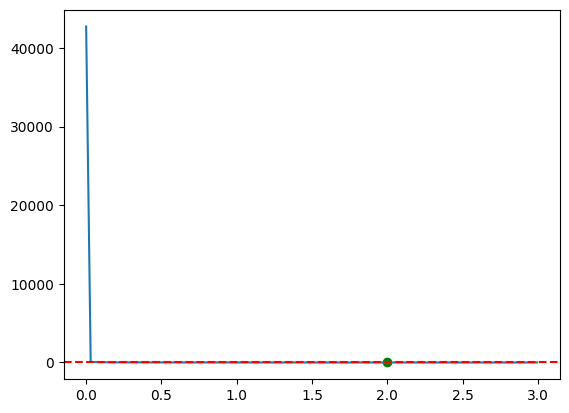

BF: 1.9938914668750707 logBF: 0.6900882402062679
Dumb BF : 1.993891466875071


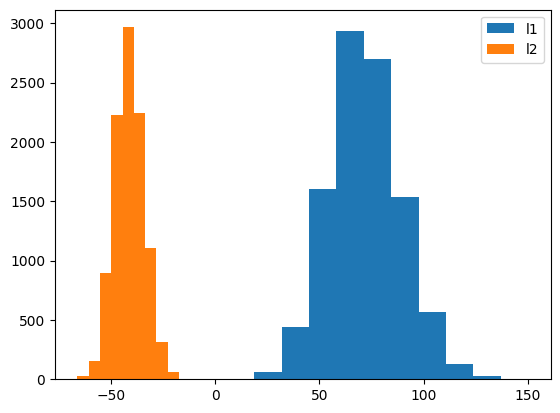

Theorical BF: 1.2200425201611975 logBF: 0.1988857107289732
Numerator = 2.0122803303327656e-06 Denominator = 1.2856284848611797e-08 BF = 156.52113764032293
Numerator = 5.142522098349499e-08 Denominator = 1.2856274072110577e-08 BF = 4.000009699159491
Numerator = 1.0028752161446462e-07 Denominator = 1.2856279460358306e-08 BF = 7.8006644086803005
Numerator = 1.0318515558222163e-06 Denominator = 1.2856284580072595e-08 BF = 80.26047878728505
Numerator = 1.8280773377394363e-07 Denominator = 1.2856282020216473e-08 BF = 14.219331334399705
Numerator = 5.660695676003846e-07 Denominator = 1.2856284126556207e-08 BF = 44.03057384451387
Numerator = 2.763654691030615e-07 Denominator = 1.2856283073386607e-08 BF = 21.496529558777148
Numerator = 3.7443867234715826e-07 Denominator = 1.2856283612379607e-08 BF = 29.124954274235424
Numerator = 3.1801249055746913e-07 Denominator = 1.2856283342883163e-08 BF = 24.735958447393035
Numerator = 3.254020791043036e-07 Denominator = 1.285628338349503e-08 BF = 25.31074

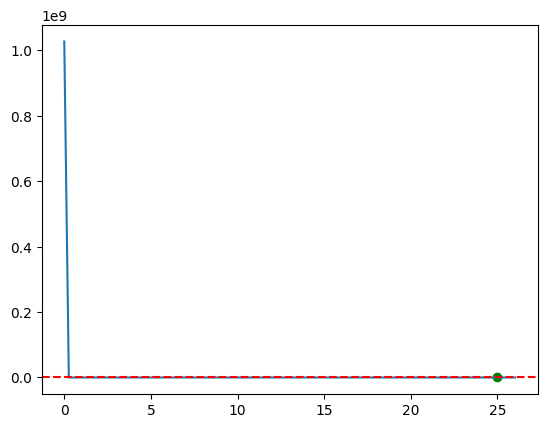

BF: 25.02170016819193 logBF: 3.219743455095891
Dumb BF : 25.02170016819193


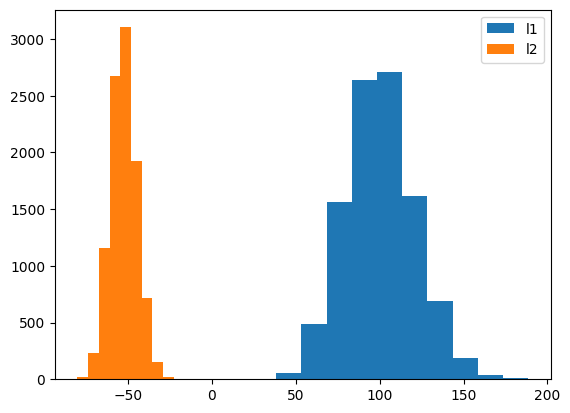

Theorical BF: 1.008228864458399 logBF: 0.008195191951472225
Numerator = 2.0873806663899388e-08 Denominator = 5.236417719874122e-17 BF = 398627607.2796036
Numerator = 2.0945671291877288e-16 Denominator = 5.23641768807419e-17 BF = 4.000000103043829
Numerator = 4.1891342163398915e-16 Denominator = 5.236417703974156e-17 BF = 8.000000101520868
Numerator = 1.0436903302245742e-08 Denominator = 5.236417719874122e-17 BF = 199313803.0725447
Numerator = 8.37826815035332e-16 Denominator = 5.23641771192414e-17 BF = 15.999999639590815
Numerator = 5.218451860579581e-09 Denominator = 5.236417719874121e-17 BF = 99656905.53627239
Numerator = 1.6756533664389167e-15 Denominator = 5.23641771589913e-17 BF = 31.999994220308206
Numerator = 2.6092263492032003e-09 Denominator = 5.2364177198741196e-17 BF = 49828460.768136054
Numerator = 3.351304586055288e-15 Denominator = 5.236417717886626e-17 BF = 63.99994741840126
Numerator = 1.3046140124282846e-09 Denominator = 5.236417719874117e-17 BF = 24914246.384065162
Nu

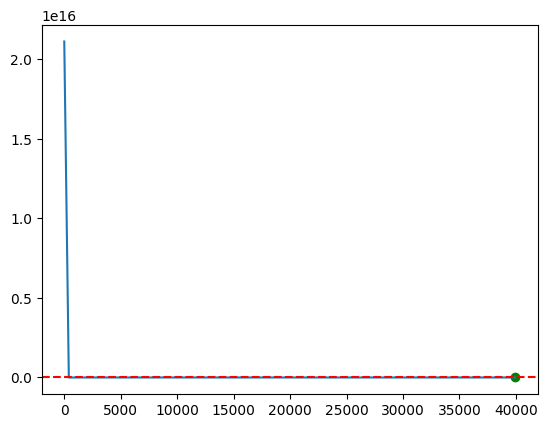

BF: 39931.32179767089 logBF: 10.594916302381177
Dumb BF : 39931.3217976709


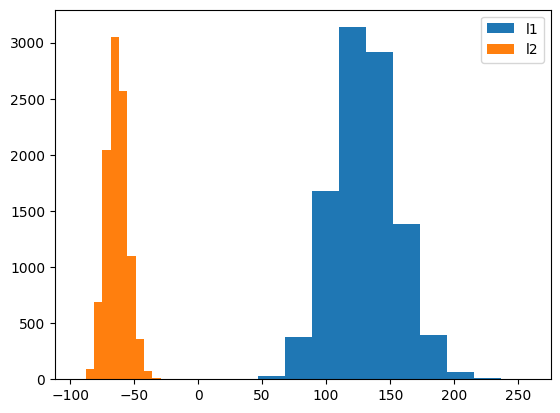

Theorical BF: 0.7995753486010004 logBF: -0.2236745064947172
Numerator = 6.964036955629572e-14 Denominator = 3.956178145150103e-21 BF = 17602940.767889377
Numerator = 1.582471258060103e-20 Denominator = 3.956178145149848e-21 BF = 4.000000000000415
Numerator = 3.1649417969354205e-20 Denominator = 3.956178145149975e-21 BF = 7.999998182122916
Numerator = 3.482019269050234e-14 Denominator = 3.956178145150103e-21 BF = 8801472.38394423
Numerator = 6.329877840400562e-20 Denominator = 3.956178145150039e-21 BF = 15.999981821244553
Numerator = 1.7410112169960155e-14 Denominator = 3.956178145150103e-21 BF = 4400740.191971207
Numerator = 1.2659709653288763e-19 Denominator = 3.95617814515007e-21 BF = 31.99984729911231
Numerator = 8.705087734369277e-15 Denominator = 3.956178145150103e-21 BF = 2200378.0959765133
Numerator = 2.5319051094509844e-19 Denominator = 3.956178145150086e-21 BF = 63.998763871512445
Numerator = 4.352607165732904e-15 Denominator = 3.956178145150103e-21 BF = 1100205.047911906
Nume

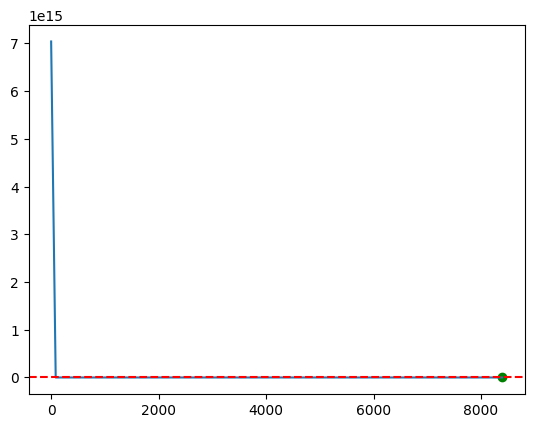

BF: 8391.171734123924 logBF: 9.034935448127552
Dumb BF : 8391.171734123924


In [235]:
N = 200
T=10000

for S in [0,100,200,300,400,500,600]:
    X_poiss_S = sample_X_poiss_given_S(S,N,T)
    X_nb_S = sample_X_nbinom_given_S(S,N,T)
    mu_poiss = post_pois_exp(S,N,T)
    mu_nb = post_nbinom_unif(S,N,T)


    l1 = np.array([logratio_pois_nb(mu,X) for mu,X in (zip(mu_poiss,X_poiss_S))])
    l2 = np.array([logratio_pois_nb(mu,X) for mu,X in (zip(mu_nb,X_nb_S))])
    l1,l2=-l2,-l1
    plt.hist(l1,label="l1")
    plt.hist(l2,label="l2")
    plt.legend()
    plt.show()
    print("Theorical BF: {} logBF: {}".format(np.exp(logBF_theo_S(S,N)),logBF_theo_S(S,N)))
    
    bridge = BF_paper(l1,l2)
    logbridge = logBF_paper(l1,l2)
    Dumb = BF_dumb(l1,l2)
    x=np.linspace(0.00000001,Dumb+1,100)
    y= np.array([func_BF_dumb(xx,l1,l2) for xx in x])-x
    plt.plot(x,y)
    plt.axhline(0,color = "red",linestyle="--")
    print("Root:",x[np.argmin(np.abs(y))])
    plt.scatter(x[np.argmin(np.abs(y))],np.min(np.abs(y)),color="green")

    plt.show()
    print("BF: {} logBF: {}".format(bridge,logbridge))
    print("Dumb BF : {}".format(Dumb))

In [233]:
np.mean(np.exp(l2)),Dumb,np.sum(np.exp(l2)/(np.exp(l2)+Dumb))

(6.606843035208806e-23, array(0.00100101), 6.600198175516234e-16)

In [195]:
func_logBF_paper(-9.566,l1,l2)

-9.566603422597286

In [144]:
func_BF_dumb(0,l1,l2)

3272631317703.3433

In [132]:
BF_dumb(l1,l2)  

array(0.00307215)

In [63]:
logBF_theo_S(S,N),np.log(BF_paper(l1,l2))#logBF_paper(l1b,l2b),

(0.008195191951472225, 1.1502616849272513)

In [285]:
np.log(BF_dumb(l1b,l2b))

-3.464020311369538

In [273]:
index = np.random.choice(len(l1),10000,replace=False)
l1c,l2c = l1[index],l2[index]

In [275]:
BF_paper(l1c,l2c)

0.11550764952196059

In [257]:
np.log(BF_paper(l1b,l2b))

-1.5512720954094357

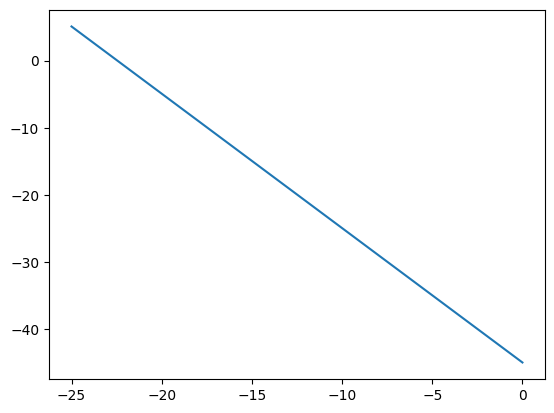

In [244]:
x = np.linspace(-25,0,20)
plt.plot(x,[func_logBF2(xx,l1b,l2b) for xx in x])

In [208]:
def func_logBF2(logBF,l1,l2):
    return func_logBF_paper(logBF,l1,l2)-logBF

In [245]:
bisect(func_logBF2,-25,0,args=(l1b,l2b))

-25 -12.5
-25 -18.75
-25 -21.875
-23.4375 -21.875
-22.65625 -21.875
-22.65625 -22.265625
-22.65625 -22.4609375
-22.55859375 -22.4609375
-22.509765625 -22.4609375
-22.4853515625 -22.4609375
-22.47314453125 -22.4609375
-22.467041015625 -22.4609375
-22.467041015625 -22.4639892578125
-22.46551513671875 -22.4639892578125
-22.46551513671875 -22.464752197265625


-22.464752197265625

In [248]:
logBF_theo_S(S,N)

0.1988857107289732

In [111]:
for i,(l1_list,l2_list) in enumerate(zip(L1,L2)):
    for j,(l1,l2) in enumerate(zip(l1_list,l2_list)):
        if i>3:
            #Bridge = BF_paper_test(l1,l2)
            logBridge = logBF_paper_test(l1,l2)
            print("S = {} Iter = {} Bridge = {} logBridge = {} ".format(S_list[i],j,Bridge,logBridge))
            print("Previous values: BF = {} logBF = {}".format(Bridge_list3[i][j],logBridge3[i][j]))

KeyboardInterrupt: 

(-1.5393632120420326, 3.45550522409871)

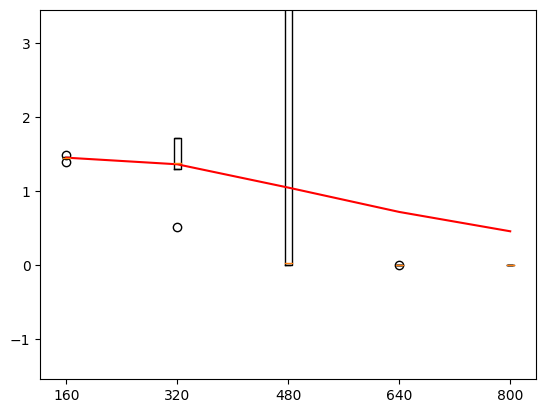

In [44]:
plt.boxplot(Bridge_list3, positions=S_list[:len(Bridge_list3)],widths=10)
plt.plot(S_list[:len(Bridge_list3)], Theo_list3[:len(Bridge_list3)], color="red")
plt.ylim(np.min(Theo_list3[:len(Bridge_list3)])-2,np.max(Theo_list3[:len(Bridge_list3)])+2)

ValueError: x and y must have same first dimension, but have shapes (21,) and (3,)

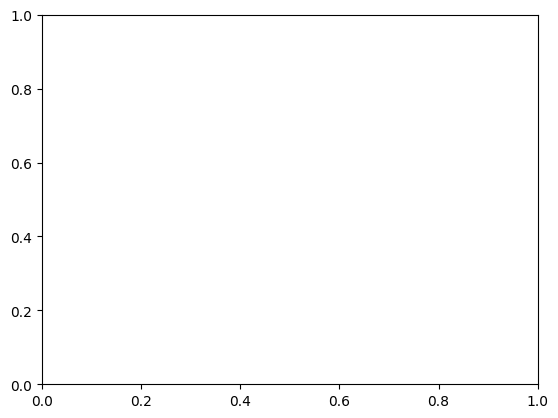

In [1382]:
# Calculate the mean and standard deviation of Bridge_list
N = 500
S_list = np.arange(0,4*N+1,(4*N)/20).astype(int)
mean_bridge = np.mean(Bridge_list3, axis=1)

std_bridge = np.std(Bridge_list3, axis=1)

alpha = 0.1
n_iter = len(Bridge_list3[0])
confidence_interval = norm.ppf(1-alpha/2) * std_bridge / np.sqrt(n_iter)

plt.plot(S_list, mean_bridge, label='Bridge logBF')
plt.fill_between(S_list, mean_bridge - confidence_interval, mean_bridge + confidence_interval, alpha=0.3, label='{}% Confidence Interval'.format(int(100-100*2*alpha)))
#plt.plot(S_list, Theo_list3, color='red', label='True value')
plt.xlabel('S')
plt.ylabel('Bridge logBF')
plt.title('Bridge logBF with {}% Confidence Interval'.format(int(100-100*2*alpha)))

plt.legend()
plt.xlim(0,400)
plt.show()


# Display CSV


In [279]:
S_list

array([  0,  22,  44,  66,  88, 111, 133, 155, 177, 200])

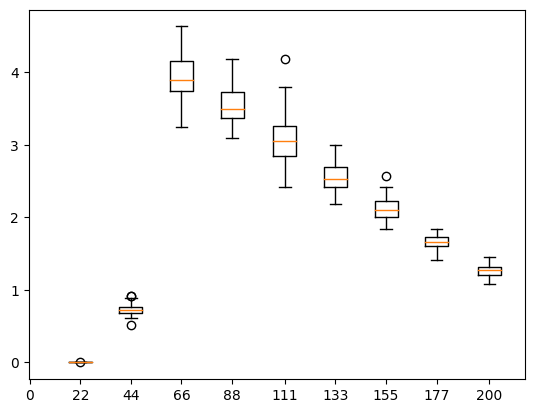

In [282]:
plt.boxplot(ABC,positions=S_list,widths=10)
x = np.linspace(0,4*N+10,100)
Theo_list = [(logBF_theo_S(S,N)) for S in x]
#plt.plot(x, np.exp(Theo_list), color="red", linestyle='--', label='Theoretical value',alpha=1, linewidth=lw)

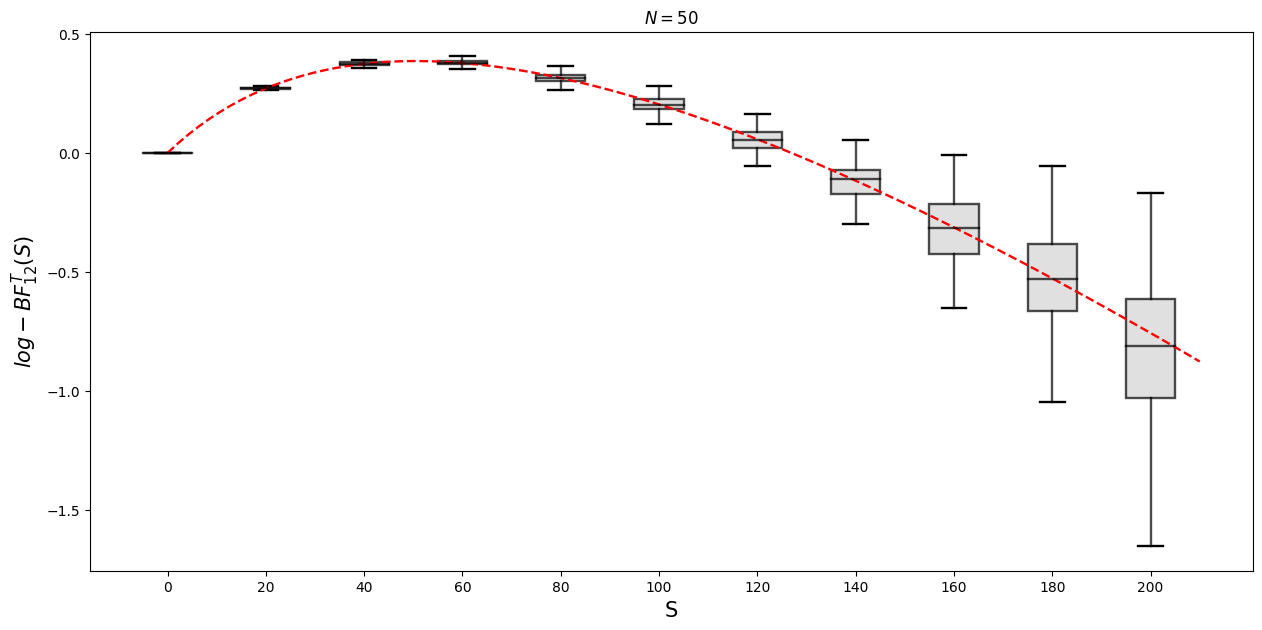

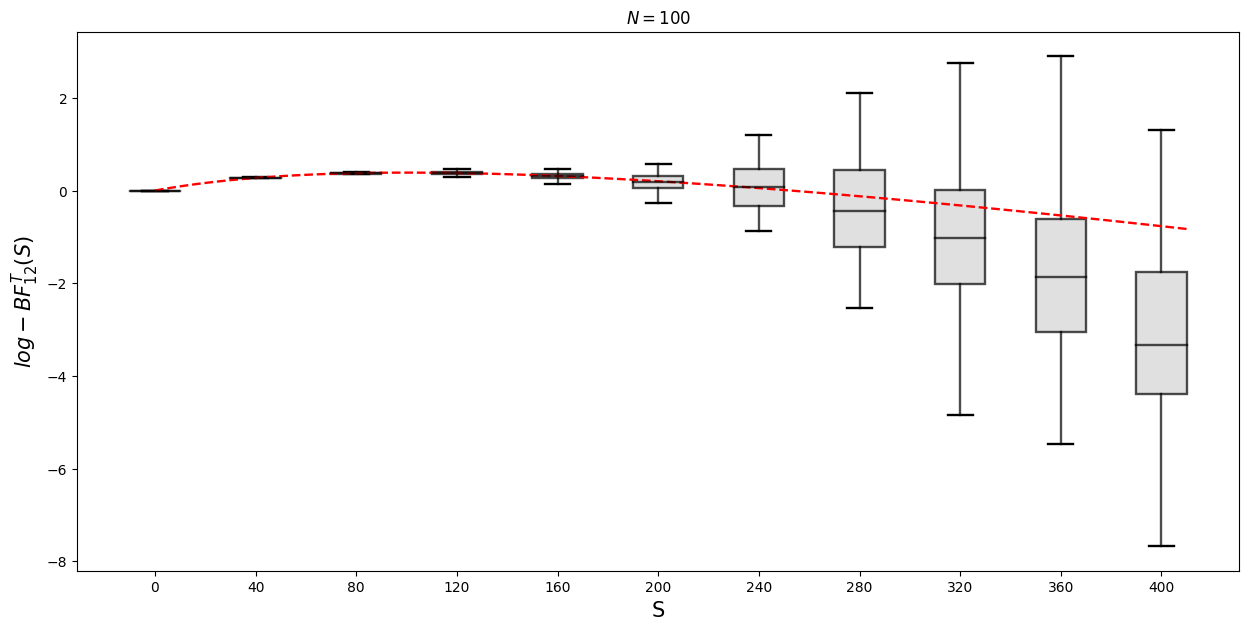

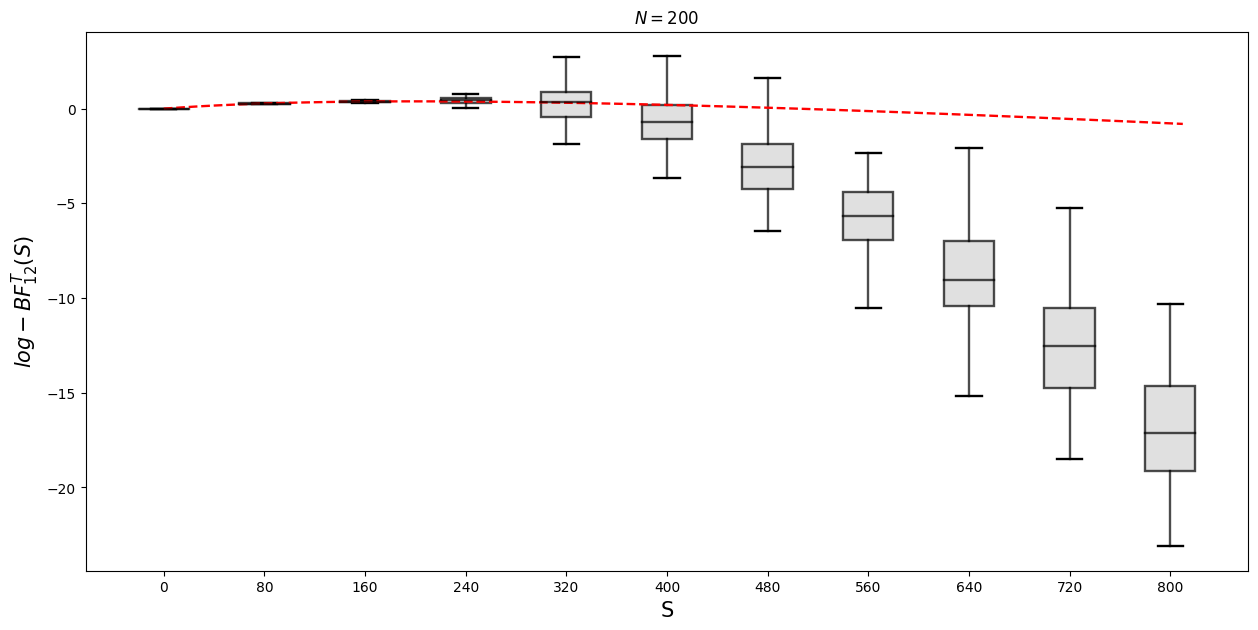

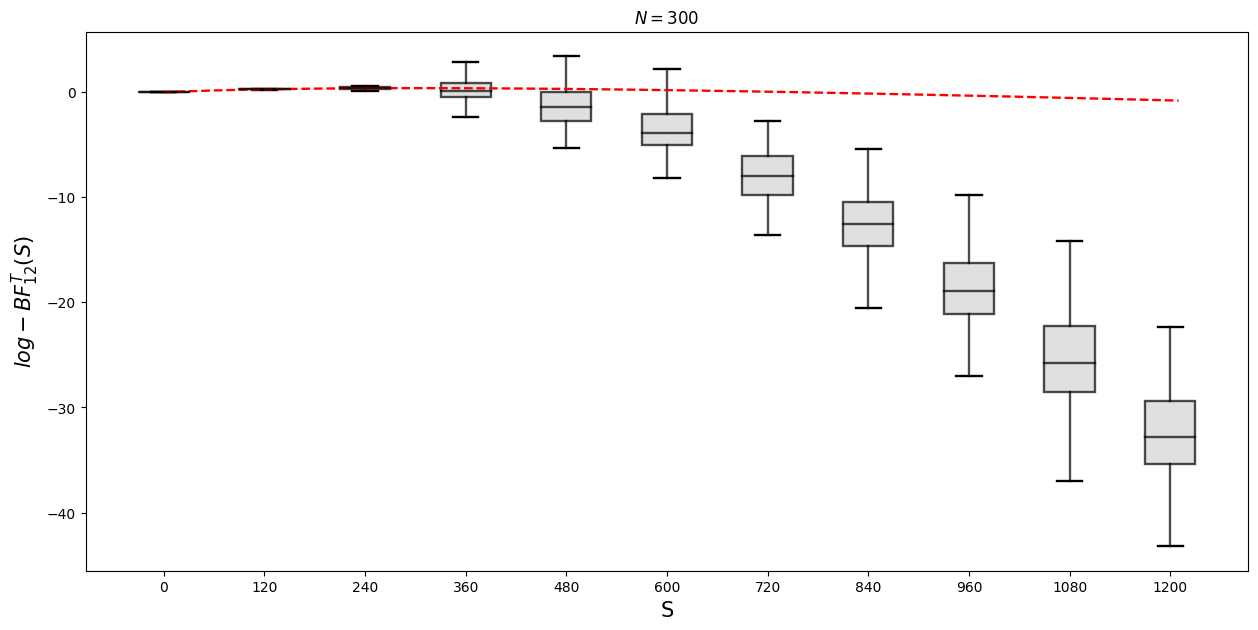

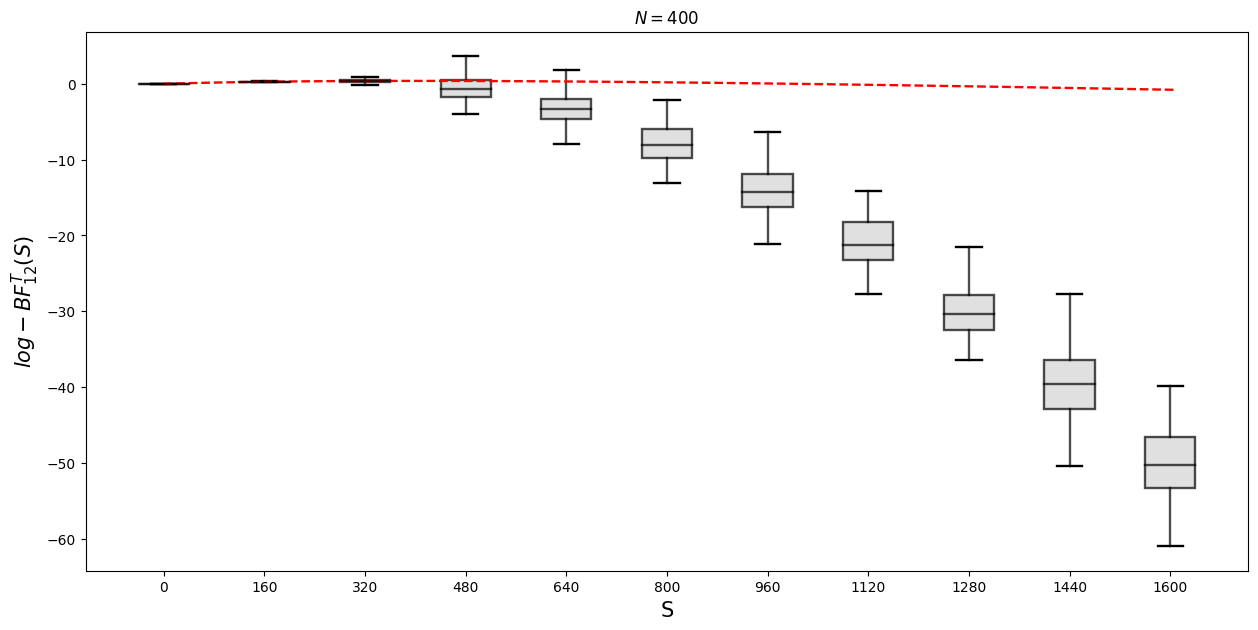

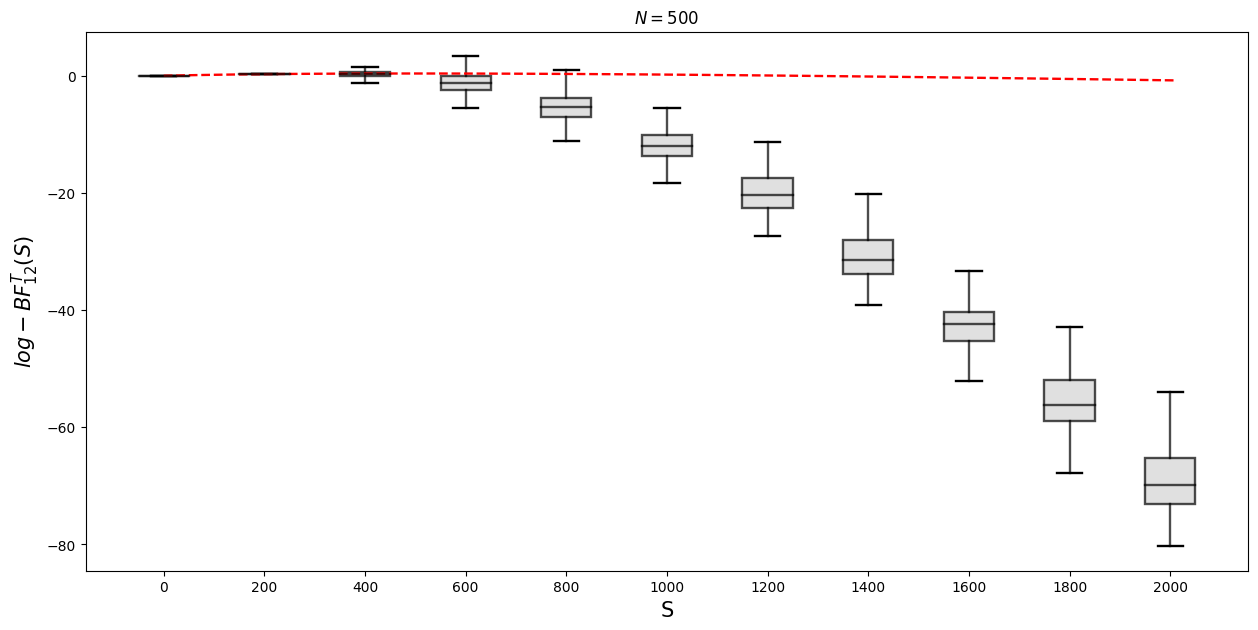

In [8]:
import csv
c1 = "black"
c2 = "lightgrey"
for N in [50,100,200,300,400,500]:
    filepath = './data/Poisson_Geo_{}.csv'.format(N)
    test_sim = []

    with open(filepath, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            test_sim.append(row)
    
    test_sim = np.array(test_sim).astype(float)[1:].T
    S_list = np.arange(0,4*N+1,(4*N)/(len(test_sim)-1)).astype(int)

    x = np.linspace(0,4*N+10,100)
    Theo_list = [(logBF_theo_S(S,N)) for S in x]
    plt.figure(figsize=(15, 7))  # Adjust the figure size as desired
    lw=1.7


    plt.boxplot(list(np.log(test_sim)), positions=S_list, widths=N/5, patch_artist=True, showfliers=False, boxprops=dict(facecolor=c2, edgecolor=c1, linewidth=lw, alpha=0.7, linestyle='--'), whiskerprops=dict(color=c1, linewidth=lw,alpha=.7), medianprops=dict(color=c1, linewidth=lw,alpha=.7), capprops=dict(color=c1, linewidth=lw))
    plt.plot(x, Theo_list, color="red", linestyle='--', label='Theoretical value',alpha=1, linewidth=lw)


    
    plt.xlabel('S', fontsize=15)
    
    # FILEPATH: /Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/Paper_Poiss_Geo.ipynb
    plt.ylabel('$log-BF_{12}^{T}(S)$', fontsize=15)
    plt.title("$N = {}$".format(N))
    
    # FILEPATH: /Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/Paper_Poiss_Geo.ipynb
    #plt.ylim(np.min(Theo_list)-1,np.max(Theo_list)+1)
    plt.show()

# Data with different T

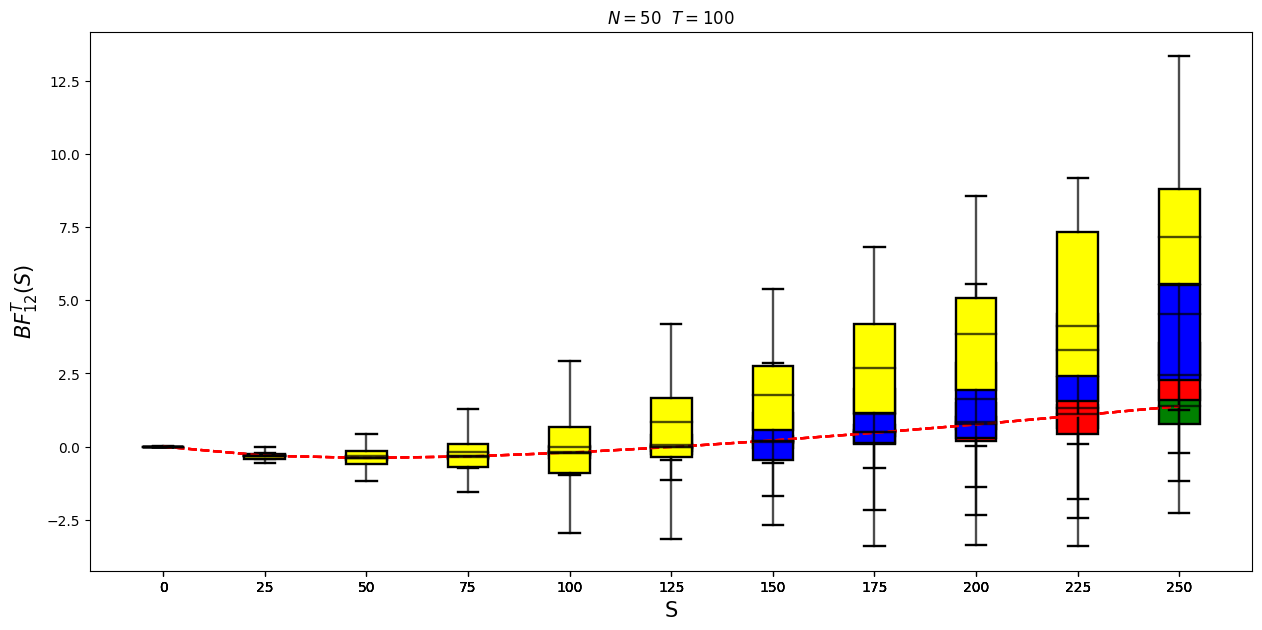

In [66]:
import csv
c1 = "black"
c2 = "lightgrey"
N = 50
plt.figure(figsize=(15, 7))  # Adjust the figure size as desired
color = ["yellow","blue","red","green"][::-1]
for i,T in enumerate([100000,10000,1000,100]):
    filepath = './data/logbridge_poiss_geo_N{}_T{}.csv'.format(N,T)
    test_sim = []

    with open(filepath, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            test_sim.append(row)
    S_list=(np.array(test_sim[0]).astype(int))
    test_sim = np.array(test_sim).astype(float)[1:].T
    Theo_list = [-(logBF_theo_S(S,N)) for S in S_list]
    # plt.figure(figsize=(15, 7))  # Adjust the figure size as desired
    lw=1.7


    plt.boxplot(list((test_sim)), positions=S_list, widths=N/5, patch_artist=True, showfliers=False, boxprops=dict(facecolor=color[i], edgecolor=c1, linewidth=lw, alpha=1, linestyle='--'), whiskerprops=dict(color=c1, linewidth=lw,alpha=.7), medianprops=dict(color=c1, linewidth=lw,alpha=.7), capprops=dict(color=c1, linewidth=lw))
    plt.plot(S_list, Theo_list, color="red", linestyle='--', label='Theoretical value',alpha=1, linewidth=lw)

    std = np.std(test_sim, axis=1)
    
    plt.xlabel('S', fontsize=15)
    # FILEPATH: /Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/Paper_Poiss_Geo.ipynb
    plt.ylabel('$BF_{12}^{T}(S)$', fontsize=15)
    plt.title("$N = {}$  $T = {}$".format(N, T))
    
    # FILEPATH: /Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/Paper_Poiss_Geo.ipynb
    #plt.ylim(np.min(Theo_list)-1,np.max(Theo_list)+1)
    #plt.show()

In [ ]:
T = 100000
for N in [50,100,200,300,400,500]:
    for S in np.linspace(0,2*N+1,2*N/):
        

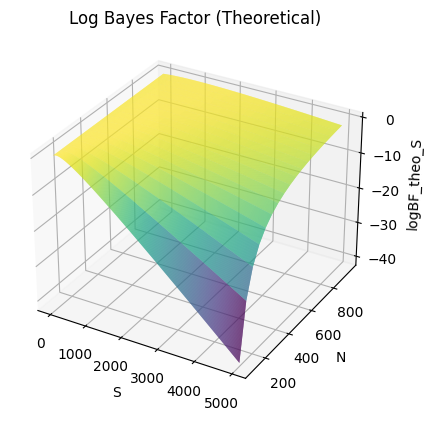

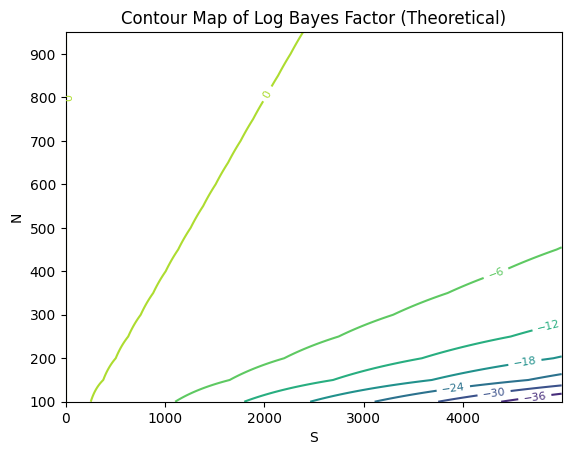

In [36]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Define the range of S and N values
S_values = np.arange(0, 5000, 10)
N_values = np.arange(100, 1000, 50)

# Create a meshgrid of S and N values
S, N = np.meshgrid(S_values, N_values)

# Calculate the logBF_theo_S for each combination of S and N
logBF_theo = logBF_theo_S(S, N)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S, N, logBF_theo,rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

# Create a contour plot
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
contour = ax2.contour(S, N, logBF_theo)
ax2.clabel(contour, inline=True, fontsize=8)

# Set labels and title for 3D plot
ax.set_xlabel('S')
ax.set_ylabel('N')
ax.set_zlabel('logBF_theo_S')
ax.set_title('Log Bayes Factor (Theoretical)')

# Set labels and title for contour plot
ax2.set_xlabel('S')
ax2.set_ylabel('N')
ax2.set_title('Contour Map of Log Bayes Factor (Theoretical)')

# Show the plots
plt.show()


# RE computation


In [1163]:
def RE_func(mu,S, N):
    return 1/(2/betaprime(S+1,N+1).pdf(mu)+2/gamma(S+1,scale=1/(N+1)).pdf(mu))

In [1231]:
N = 1009
T = 10000

S_list = np.arange(0,4*N,20)
RE_list = []
for S in S_list:
    RE = 1/quad(RE_func, 0, np.inf, args=(S,N))[0]- 2
    #print("S = {} RE = {}".format(S,RE))
    RE_list.append(RE)
plt.plot(S_list, RE_list)

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


KeyboardInterrupt: 

In [1050]:
Gamma = []
Beta = []
N = 50
eps=.001
for S in tqdm(S_list):
    law_b = betaprime(S+1,N+1)
    law_g = gamma(S+1,scale=1/(N+1))
    Gamma.append([law_g.ppf(eps),law_g.ppf(1-eps)])
    Beta.append([law_b.ppf(eps),law_b.ppf(1-eps)])
    

100%|██████████| 150/150 [00:00<00:00, 338.22it/s]


# Overlap $\pi(\theta\mid y)$


In [40]:
def p1_p2(mu,y):
    return np.prod(poisson(mu=mu).pmf(y)*nbinom(n=1,p=1/(1+mu).pmf(y)))*expon.pdf(mu)+(1+mu)**2 

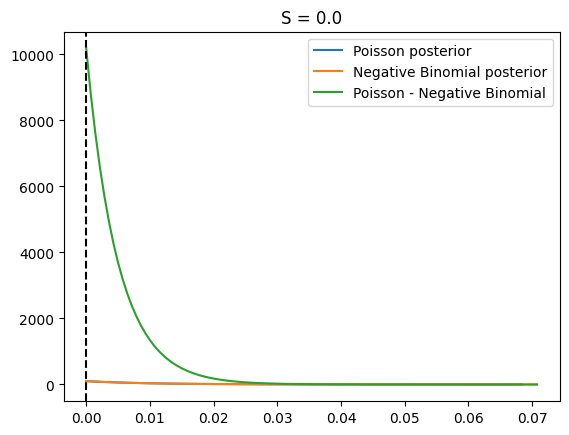

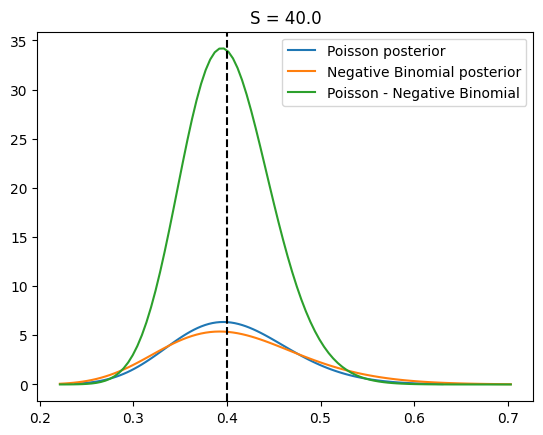

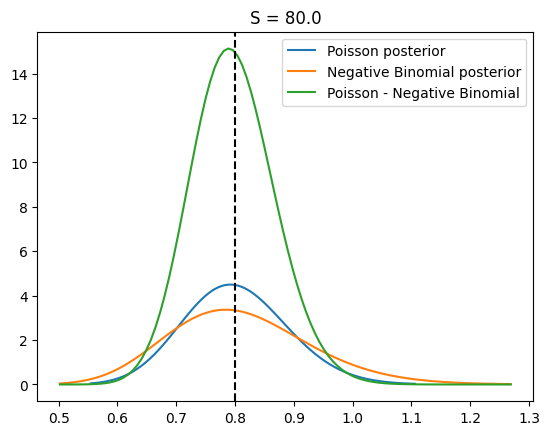

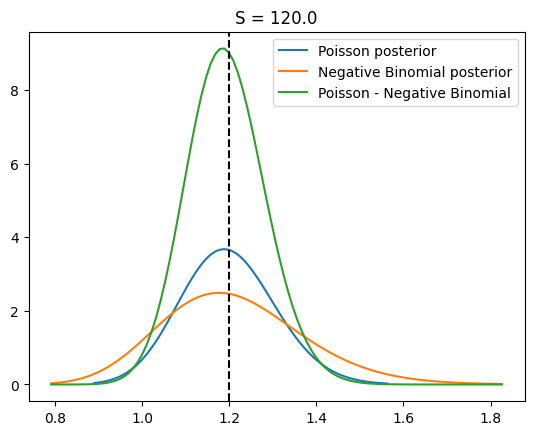

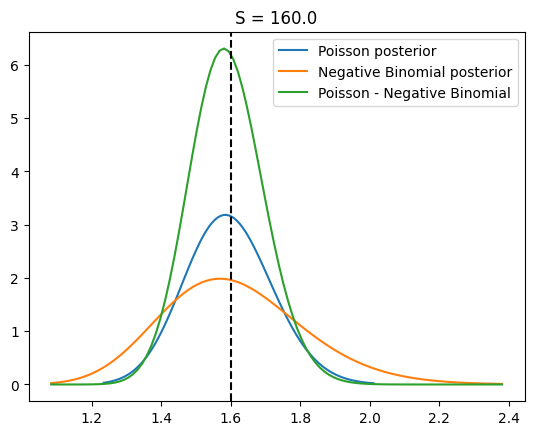

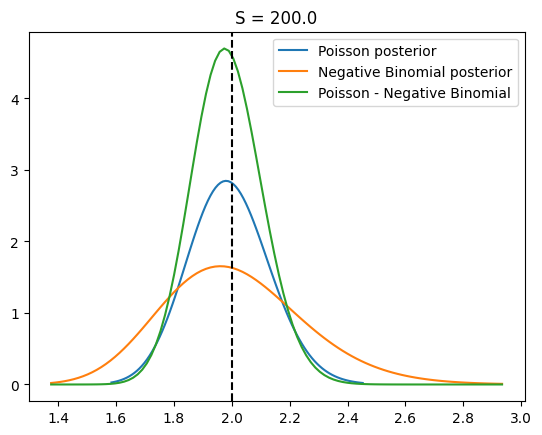

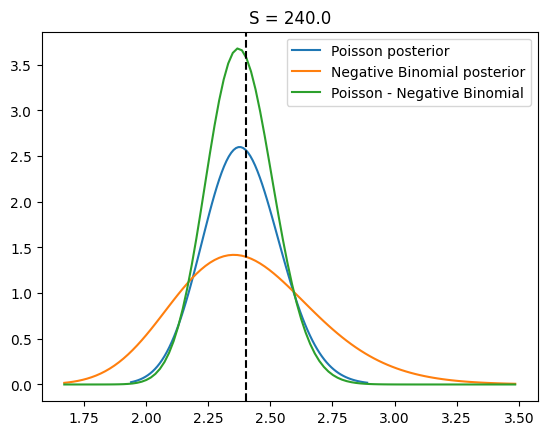

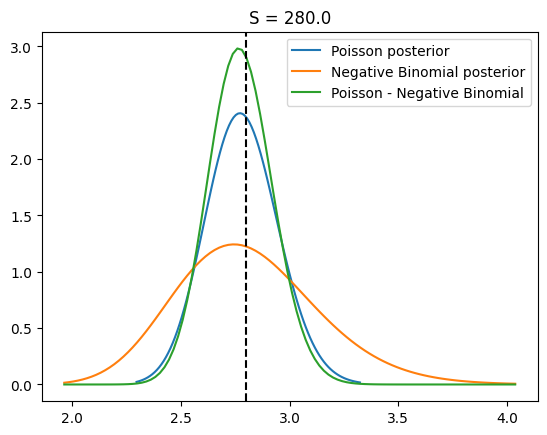

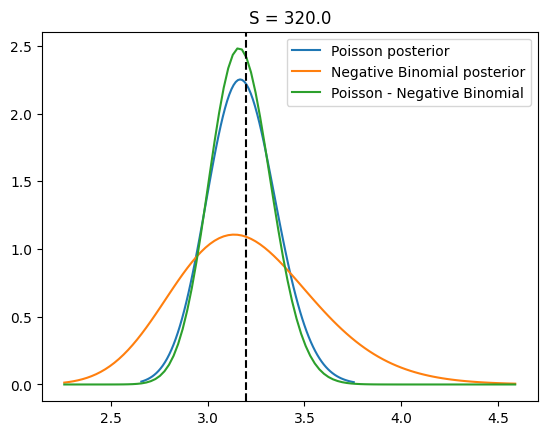

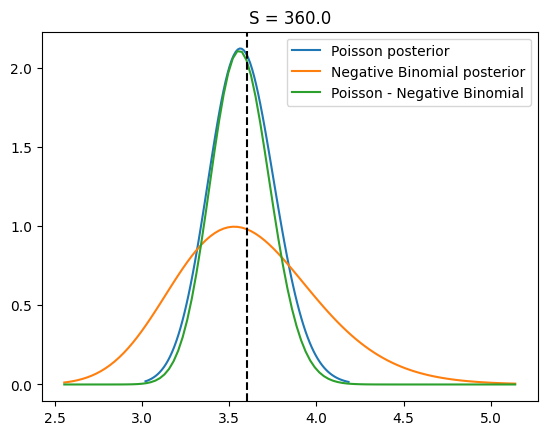

In [39]:
N = 100
S_list = np.arange(0,4*N,4*N/10)
for S in S_list:
    law1 = gamma(S+1,scale=1/(N+1))
    x = np.linspace(law1.ppf(0.001),law1.ppf(0.999), 100)
    plt.plot(x, law1.pdf(x), label="Poisson posterior")
    law2 = betaprime(S+1,N+1)
    x = np.linspace(law2.ppf(0.001),law2.ppf(0.999), 100)
    plt.plot(x, law2.pdf(x), label="Negative Binomial posterior")
    x = np.linspace(min(law1.ppf(0.001),law2.ppf(0.001)),max(law1.ppf(0.999),law2.ppf(0.999)), 100)
    plt.plot(x, law1.pdf(x)*law2.pdf(x), label="Poisson - Negative Binomial")
    plt.axvline(S/N, color="black", linestyle="--")
    plt.plot()
    plt.title("S = {}".format(S))
    plt.legend()
    plt.show()

In [1181]:
quad(lambda x: gamma(S+1, scale=1/(N+1)).pdf(x), 0, np.inf)

(0.999999999999988, 1.490209487301561e-09)

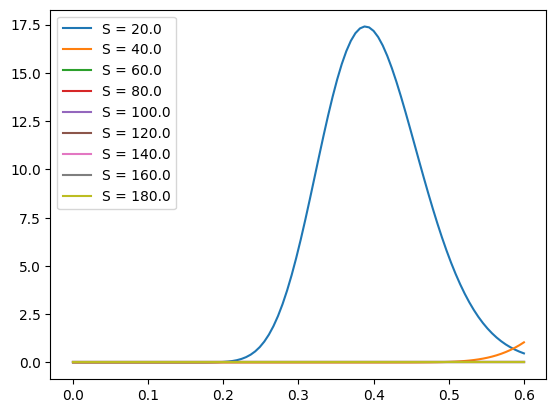

In [1194]:
x = np.linspace(0,.6,100)
N = 50
S_list = np.arange(0,4*N,4*N/10)
for S in S_list[1:]:
    plt.plot(x,gamma(S+1,scale=1/(N+1)).pdf(x)*betaprime(S+1,N+1).pdf(x), label="S = {}".format(S))
plt.legend()

In [1179]:
N = 50
S_list = np.arange(0,4*N,4*N/100)
overlap50 = [quad(lambda x: gamma(S+1,scale=1/(N+1)).pdf(x)*betaprime(S+1,N+1).pdf(x), 0, np.inf)[0] for S in tqdm(S_list)]

N = 100
S_list = np.arange(0,4*N,4*N/100)
overlap100 = [quad(lambda x: gamma(S+1,scale=1/(N+1)).pdf(x)*betaprime(S+1,N+1).pdf(x), 0, np.inf)[0] for S in tqdm(S_list)]

N = 1000
S_list = np.arange(0,4*N,4*N/100)
overlap1000 = [quad(lambda x: gamma(S+1,scale=1/(N+1)).pdf(x)*betaprime(S+1,N+1).pdf(x), 0, np.inf)[0] for S in tqdm(S_list)]



100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


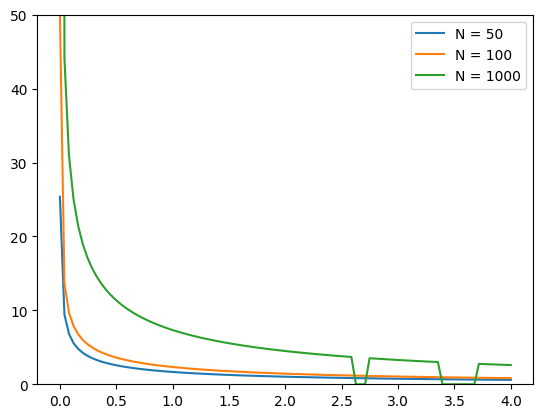

In [1235]:
mu_list =np.linspace(0,4,100)
plt.plot(mu_list, overlap50, label="N = 50")
plt.plot(mu_list, overlap100, label="N = 100")
plt.plot(mu_list, overlap1000, label="N = 1000")
plt.ylim(0,50)
plt.legend()

# Overlap $y$

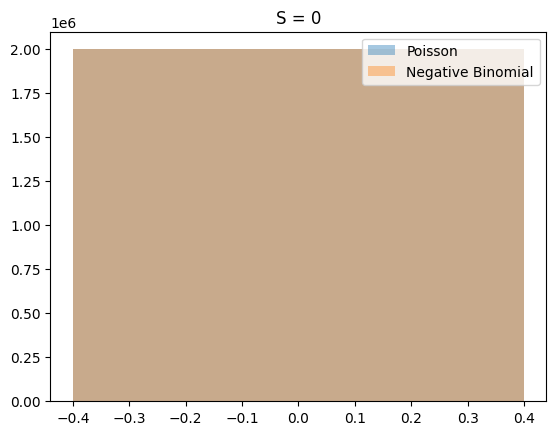

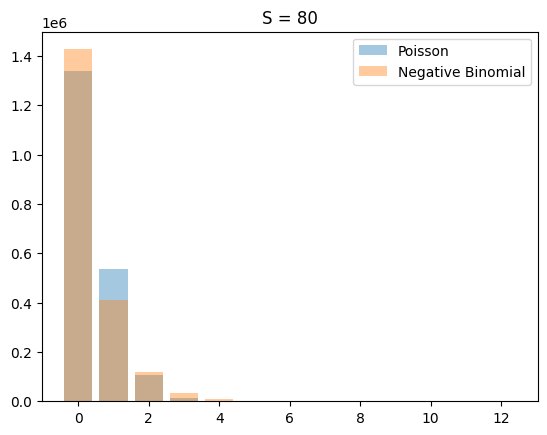

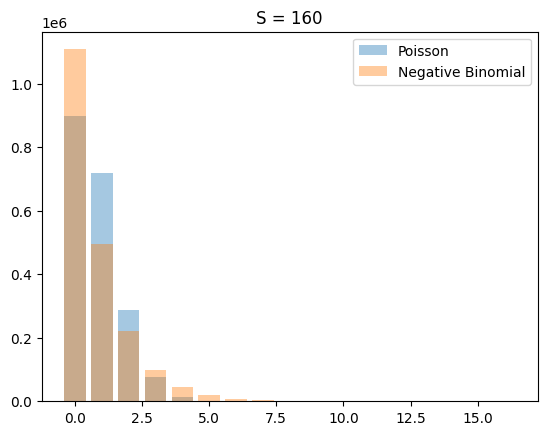

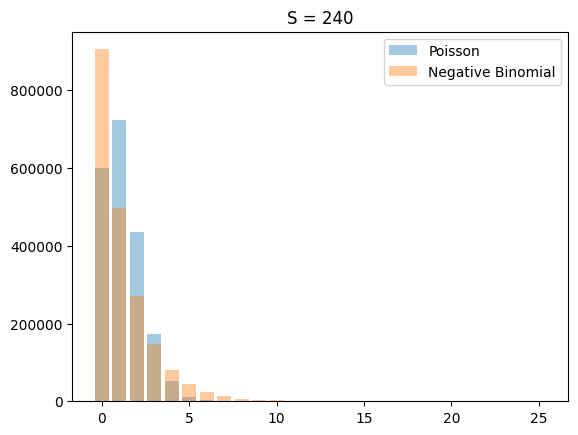

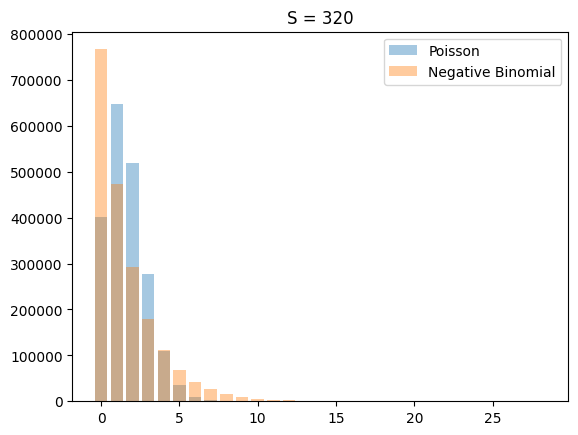

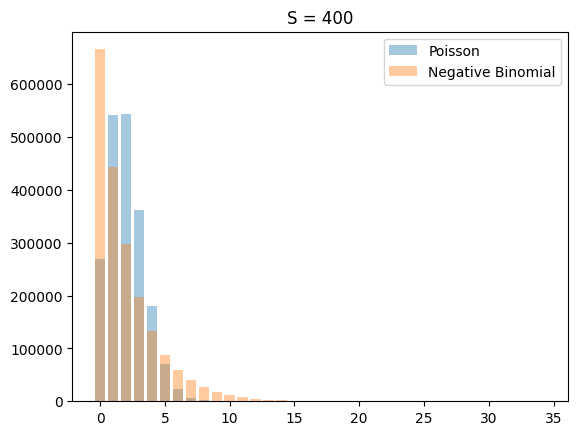

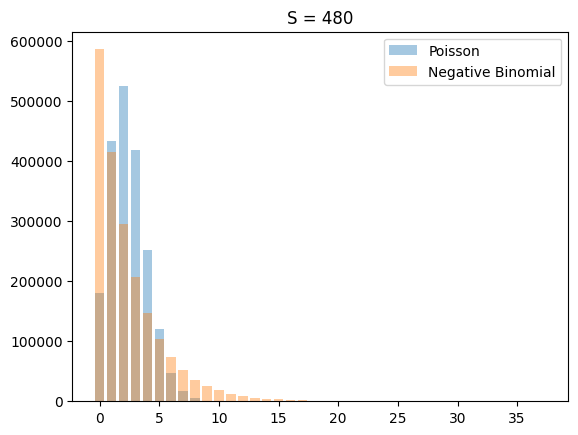

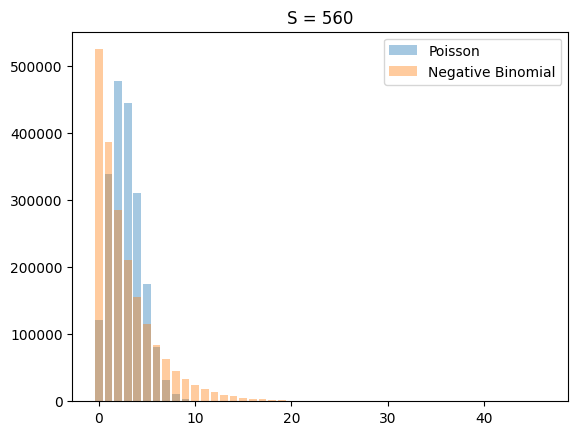

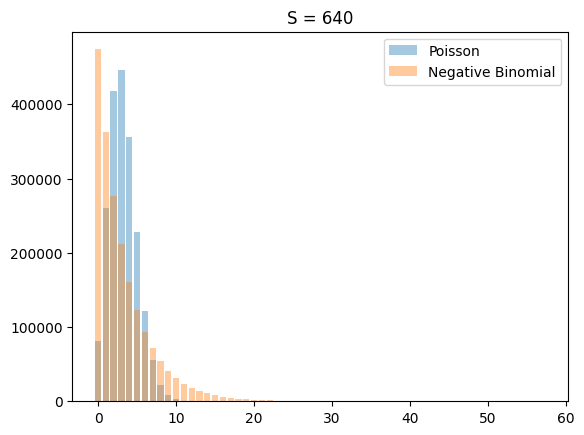

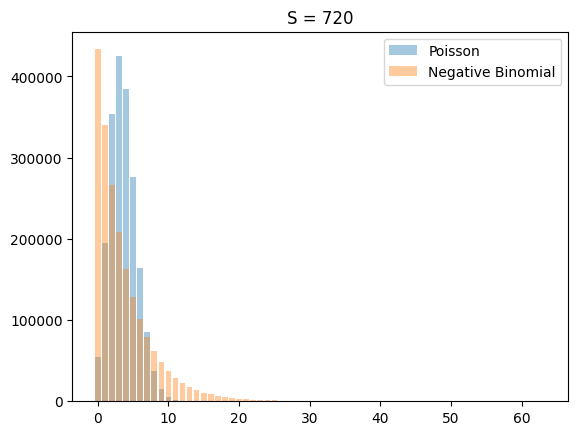

In [82]:
N = 200
S_list = np.arange(0,4*N,4*N/10).astype(int)
for S in S_list:
    X_pois = sample_X_poiss_given_S(S,N,10000)
    X_geo = sample_X_nbinom_given_S(S,N,10000)
    value_pois, counts_pois = np.unique(X_pois, return_counts=True)
    value_geo, counts_geo = np.unique(X_geo, return_counts=True)
    plt.bar(value_pois, counts_pois, label="Poisson",alpha=.4)
    plt.bar(value_geo, counts_geo, label="Negative Binomial",alpha=.4)
   
    plt.title("S = {}".format(S))
    plt.legend()
    plt.show()
    


Text(0.5, 0, 'S')

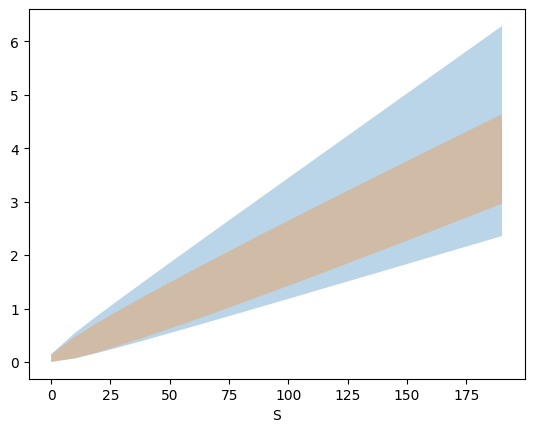

In [1144]:
N = 50 
S_list = np.arange(0,4*N,10)
Q_gamma,Q_beta= [],[]
for S in S_list: 
    law = gamma(S+1,scale=1/(N+1))
    Q_gamma.append([law.ppf(eps),law.ppf(1-eps)])
    law = betaprime(S+1,N+1)
    Q_beta.append([law.ppf(eps),law.ppf(1-eps)])
    
Q_gamma = np.array(Q_gamma)
Q_beta = np.array(Q_beta)

plt.fill_between(S_list, Q_beta[:,0], Q_beta[:,1], alpha=0.3, label='Quantile 99% Beta')
plt.fill_between(S_list, Q_gamma[:,0], Q_gamma[:,1], alpha=0.3, label='Quantile 99% Gamma')

plt.xlabel("S")


In [1051]:
B_mean = []
G_mean = []
N = 50
for S 

100%|██████████| 150/150 [00:00<00:00, 1256.80it/s]


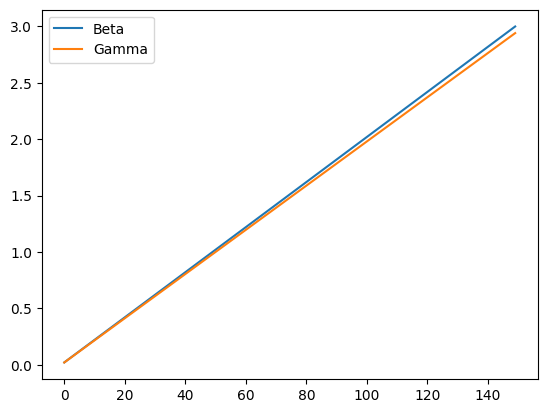

In [1052]:
plt.plot(S_list,B_mean, label="Beta")
plt.plot(S_list,G_mean, label="Gamma")
plt.legend()


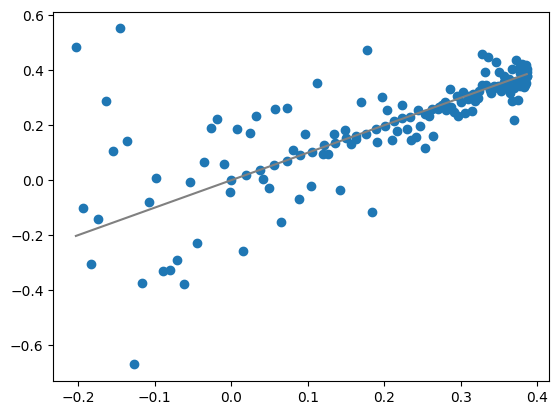

In [1054]:
plt.scatter(Theo_list, Bridge_list, label="Poisson")
x = np.linspace(np.min(Theo_list),np.max(Theo_list),1000)
plt.plot(x,x, color="grey")


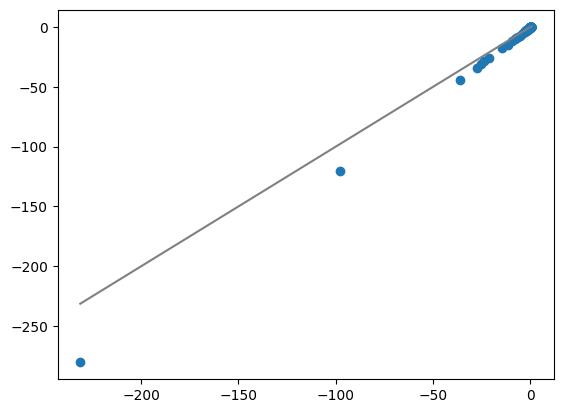

In [ ]:
plt.scatter(Theo_NB, Bridge_NB, label="Negative Binomial")
x=np.linspace(np.min(Theo_NB),np.max(Theo_NB),100)
plt.plot(x,x, color="grey")

In [ ]:
N = 1000
n_iter= 100
T = 10000
Bridge_Poiss2, Bridge_NB2 = [],[],[],[]
S = 100
theo = logBF_theo_S(S,N)
for _ in tqdm(range(n_iter)):
    theo_nb = logBF_theo_S(S_nb,N)
    mu_nb = post_nbinom_unif(S_nb,N,T)
    mu_poiss = post_pois_exp(S_nb,N,T)
    lratio_num = -np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb)])
    lratio_den = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_nb)])
    Bridge_nb = logBF_logsumexp_fixedpoint(lratio_num,lratio_den)
    print("Nbinom S = {} Theoretical logBF = {} Bridge logBF = {}".format(S_nb,theo_nb,Bridge_nb))
    
    p = np.random.uniform(size=1)
    mu = expon(1).rvs(1)
    X_pois = poisson.rvs(mu, size=N)
    S_pois = np.sum(X_pois)
    mu_nb = post_nbinom_unif(S_pois,N,T)
    mu_poiss = post_pois_exp(S_pois,N,T)
    lratio_num = -np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_pois)])
    lratio_den = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_pois)])
    Bridge_pois = logBF_logsumexp_fixedpoint(lratio_num,lratio_den)
    print("Poisson S = {} Theoretical logBF = {} Bridge logBF = {}".format(S_pois,theo_pois,Bridge_pois))
    
    Bridge_Poiss2.append(Bridge_pois)
    Bridge_NB2.append(Bridge_nb)
    